# Plot track intensity over time 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys 
import os
sys.path.append('../src/')
from intensity_time_plots import filter_track_ids_by_length_ranges, random_track_ids
from intensity_time_plots import intensity_time_plot, createBufferForLifetimeCohort
from intensity_time_plots import createBufferForLifetimeCohort_normalized, cumulative_plots, cumulative_plots_ax

In [2]:
###### Set the following variables #######


# Background intensity for each channel

background_channel_1 = 240
background_channel_2 = 150
background_channel_3 = 170

# framerate (in milliseconds)

framerate_msec = 2500

# protein names (optional)

channel1_name = 'Arp2/3-Halo'
channel2_name = 'Dynamin2-tagGFP2'
channel3_name = 'AP2-tagRFPt'

### Which type of intensity to report per spot
Options:
* voxel_sum_adjusted (default): background-subtracted sum intensity
* voxel_sum: sum intensity
* peak_mean: mean intensity
* peak_max: max intensity


In [3]:
value_to_plot = 'voxel_sum_adjusted'
# value_to_plot = 'voxel_sum'
# value_to_plot = 'peak_mean'
# value_to_plot = 'peak_max'

if value_to_plot == 'voxel_sum_adjusted':
    background_channel_1 = 0
    background_channel_2 = 0
    background_channel_3 = 0

# use this list to see all possible values to plot
# track_df.columns

In [4]:
# This assumes that your notebook is inside 'Jupyter Notebooks', which is at the same level as 'test_data'
base_dir = os.path.join(os.path.dirname(os.path.abspath("__file__")), '..', 'movie_data')

zarr_directory = 'zarr_file/all_channels_data'
zarr_full_path = os.path.join(base_dir, zarr_directory)

input_directory = 'datasets'
input_file_name = 'track_df_cleaned_final_full.pkl'
input_directory_all_tracks_full = os.path.join(base_dir,input_directory, input_file_name)

input_file_name = 'filtered_tracks_final.pkl'
input_directory_full_filtered_tracks = os.path.join(base_dir,input_directory , input_file_name)

In [5]:
track_df = pd.read_pickle(input_directory_all_tracks_full)
filtered_tracks = pd.read_pickle(input_directory_full_filtered_tracks)

Set which region to plot. Default is 'All'

In [6]:
# region_to_plot = 'Apical'
# region_to_plot = 'Lateral'
# region_to_plot = 'Basal'
region_to_plot = 'All'

if region_to_plot != 'All':
    filtered_tracks_all = filtered_tracks
    filtered_tracks = filtered_tracks_all[filtered_tracks_all['membrane_region'] == region_to_plot]

print('You are about to plot the following region: ', region_to_plot)


You are about to plot the following region:  All


Define cohort sizes

In [7]:
# range of track lengths to plot in each cohort, in frames
custom_length_ranges = [[5, 10], [11,15], [16, 20], [21, 25], [26, 30], [31, 40], [41,90]]

## Pick which channel(s) to plot

In [8]:
# by default you always plot channel 3 positive (fixing this)

# e.g. [True, True] to plot all three channels
# or [True, False] to plot channels 1 and 2

channels_to_plot = [True, True]

tracks_channel_subset = filtered_tracks[(filtered_tracks['channel1_positive'] == channels_to_plot[0]) &
                                 (filtered_tracks['channel2_positive'] == channels_to_plot[1])]

# will get this to work:

# e.g. [True, True, True] to plot all three channels
# or [True, False, True] to plot channels 1 and 3

# channels_to_plot = [True, True, True]

# tracks_channel_subset = filtered_tracks[(filtered_tracks['channel1_positive'] == channels_to_plot[0]) &
#                                  (filtered_tracks['channel2_positive'] == channels_to_plot[1]) &
#                                  (filtered_tracks['channel3_positive'] == channels_to_plot[2])]

# tracks_channel_subset.head()

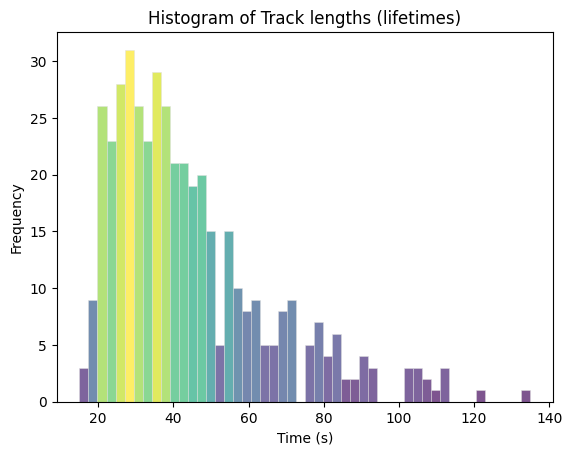

In [9]:
# Plot histogram of all track lengths (lifetimes)

# 'all lifetimes' is a variable of all the track lengths, multipilied by time per track

all_lifetimes =  tracks_channel_subset['track_length']*framerate_msec/1000

n, bins, patches = plt.hist(all_lifetimes, bins=50, facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)

n = n.astype('int')

# Good old loop. Choose colormap of your taste
for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))

#plt.hist(all_lifetimes, bins=50, edgecolor=black)
plt.xlabel('Time (s)')  # X-axis label
plt.ylabel('Frequency')  # Y-axis label
plt.title('Histogram of Track lengths (lifetimes)')  # Title of the histogram
plt.show()

In [10]:
track_id_arrays = filter_track_ids_by_length_ranges(dataframe = tracks_channel_subset, track_length_buckets = custom_length_ranges, 
                                 track_id_col_name = 'track_id', track_length_col_name = 'track_length')

print(f'number of tracks between [5,10] frames long are {len(track_id_arrays[0])}')
print(f'number of tracks between [11,15] frames long are {len(track_id_arrays[1])}')
print(f'number of tracks between [16,20] frames long are {len(track_id_arrays[2])}')
print(f'number of tracks between [21,25] frames long are {len(track_id_arrays[3])}')
print(f'number of tracks between [26,30] frames long are {len(track_id_arrays[4])}')
print(f'number of tracks between [31,40] frames long are {len(track_id_arrays[5])}')
print(f'number of tracks between [41,90] frames long are {len(track_id_arrays[6])}')

number of tracks between [5,10] frames long are 89
number of tracks between [11,15] frames long are 135
number of tracks between [16,20] frames long are 96
number of tracks between [21,25] frames long are 47
number of tracks between [26,30] frames long are 32
number of tracks between [31,40] frames long are 28
number of tracks between [41,90] frames long are 14


In [11]:
# Statistics of track lengths for each condition

Plot random tracks

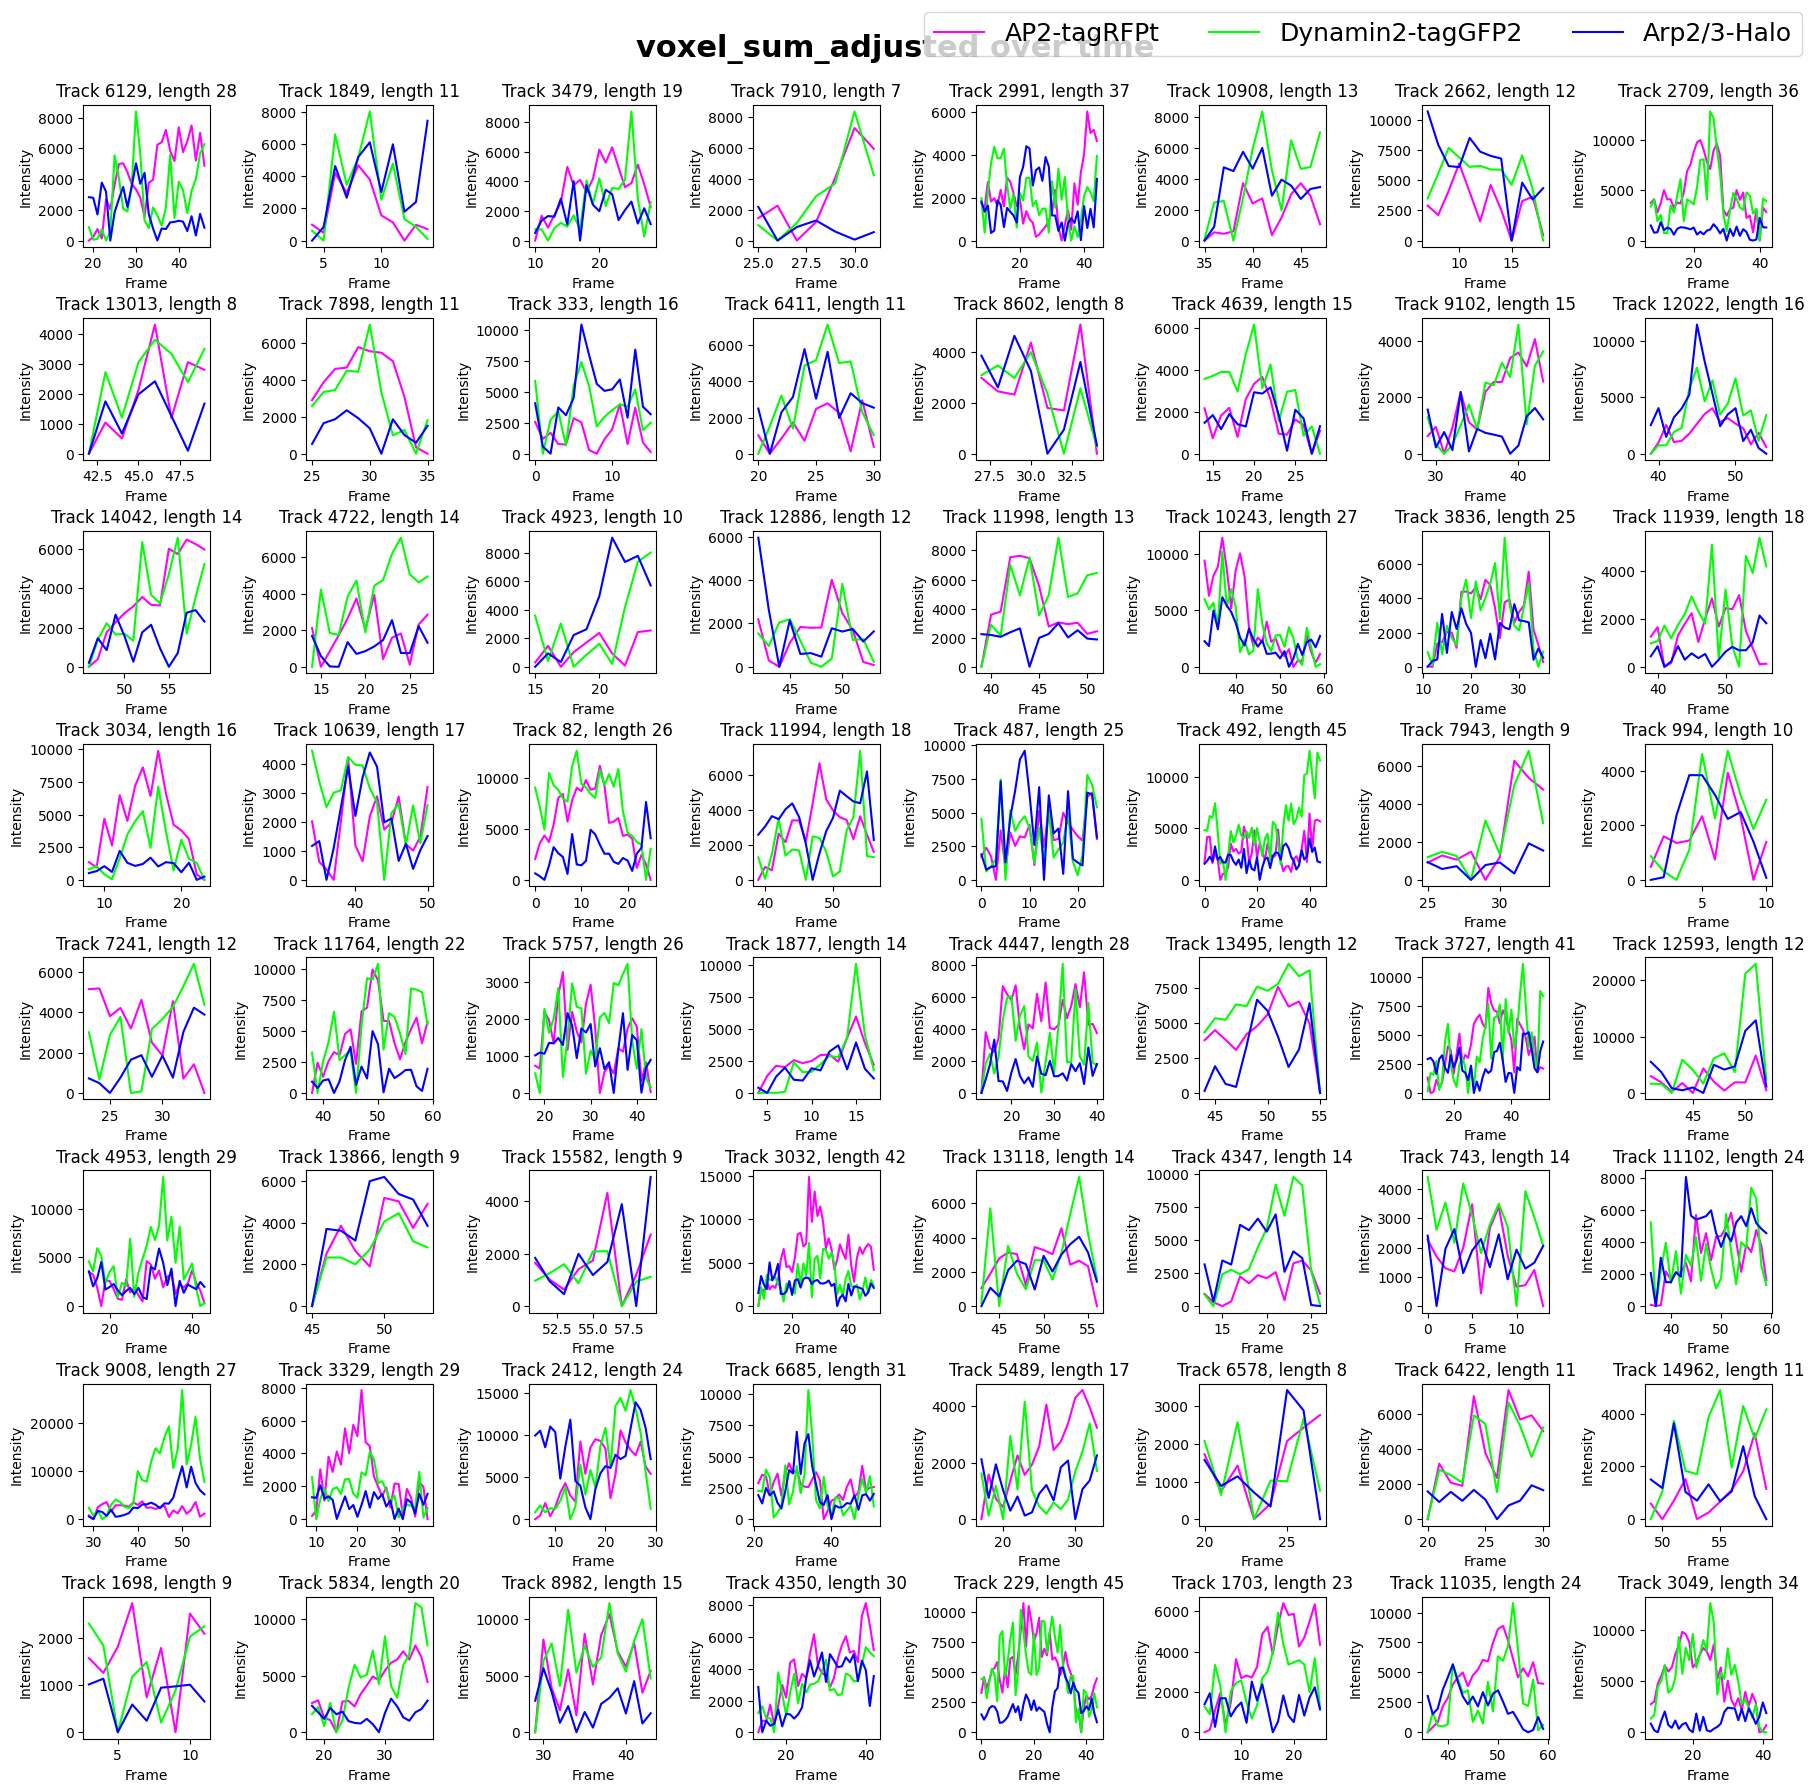

In [12]:
# set 'normalized = False' to plot raw intensities

random_tracks = random_track_ids(dataframe = tracks_channel_subset, desired_length = [0, np.inf], 
                                 track_length_col_name = 'track_length', track_id_col_name = 'track_id', 
                                num_to_select = 64)

intensity_time_plot(dataframe = track_df, tracks_to_plot = random_tracks, 
intensity_to_plot = [f'c3_{value_to_plot}',f'c2_{value_to_plot}', f'c1_{value_to_plot}'], track_id_col_name = 'track_id', 
frame_col_name = 'frame', channels_to_plot = 3, legend_values = [channel3_name, channel2_name, channel1_name],
line_colors = ['magenta', 'lime', 'blue'], graph_title = f'{value_to_plot}', normalized=False)

In [13]:
# Uncomment to plot random tracks from a specific lifetime cohort
# ## Pick which lifetime cohort to plot from, between 0 (shortest tracks) to 6 (longest tracks)

# cohort_to_plot = 3

# print("plotting tracks between " + str(custom_length_ranges[3][0]) + " and " + str(custom_length_ranges[3][1]) + " frames long")

# ### Select random track ids of a desired length 

# random_tracks = random_track_ids(dataframe = channel_subset, desired_length = custom_length_ranges[cohort_to_plot], 
#                                  track_length_col_name = 'track_length', track_id_col_name = 'track_id', 
#                                 num_to_select = 64)

# ### The amplitude used for plotting is voxel sum from both channels. Minimum voxel sum is subtracted from all values to try and bring starting intensities close to zero

# intensity_time_plot(dataframe = track_df, tracks_to_plot = random_tracks, 
# intensity_to_plot = [f'c3_{value_to_plot}',f'c2_{value_to_plot}', f'c1_{value_to_plot}'], track_id_col_name = 'track_id', 
# frame_col_name = 'frame', channels_to_plot = 3, legend_values = ['Channel 3', 'Channel 2', 'Channel 1'],
# line_colors = ['magenta', 'lime', 'blue'], graph_title = f'{value_to_plot}')

In [14]:
# primary_buffer, secondary_buffer, tertiary_buffer = createBufferForLifetimeCohort(dataframe = track_df ,
# listOfTrackIdsAssignedToCohort = track_id_arrays[2], backgroundIntensity = [background_channel_3, background_channel_2, background_channel_1], 
# intensity_to_plot = [f'c3_{value_to_plot}',f'c2_{value_to_plot}', f'c1_{value_to_plot}'], track_id_col_name = 'track_id')

# # visualize alignment of tracks

# plt.figure(dpi=300)
# plt.title(channel3_name)
# plt.imshow(primary_buffer)

# plt.figure(dpi=300)
# plt.title(channel2_name)
# plt.imshow(secondary_buffer)

# plt.figure(dpi=300)
# plt.title(channel1_name)
# plt.imshow(tertiary_buffer)


## Intensity plots by lifetime cohort

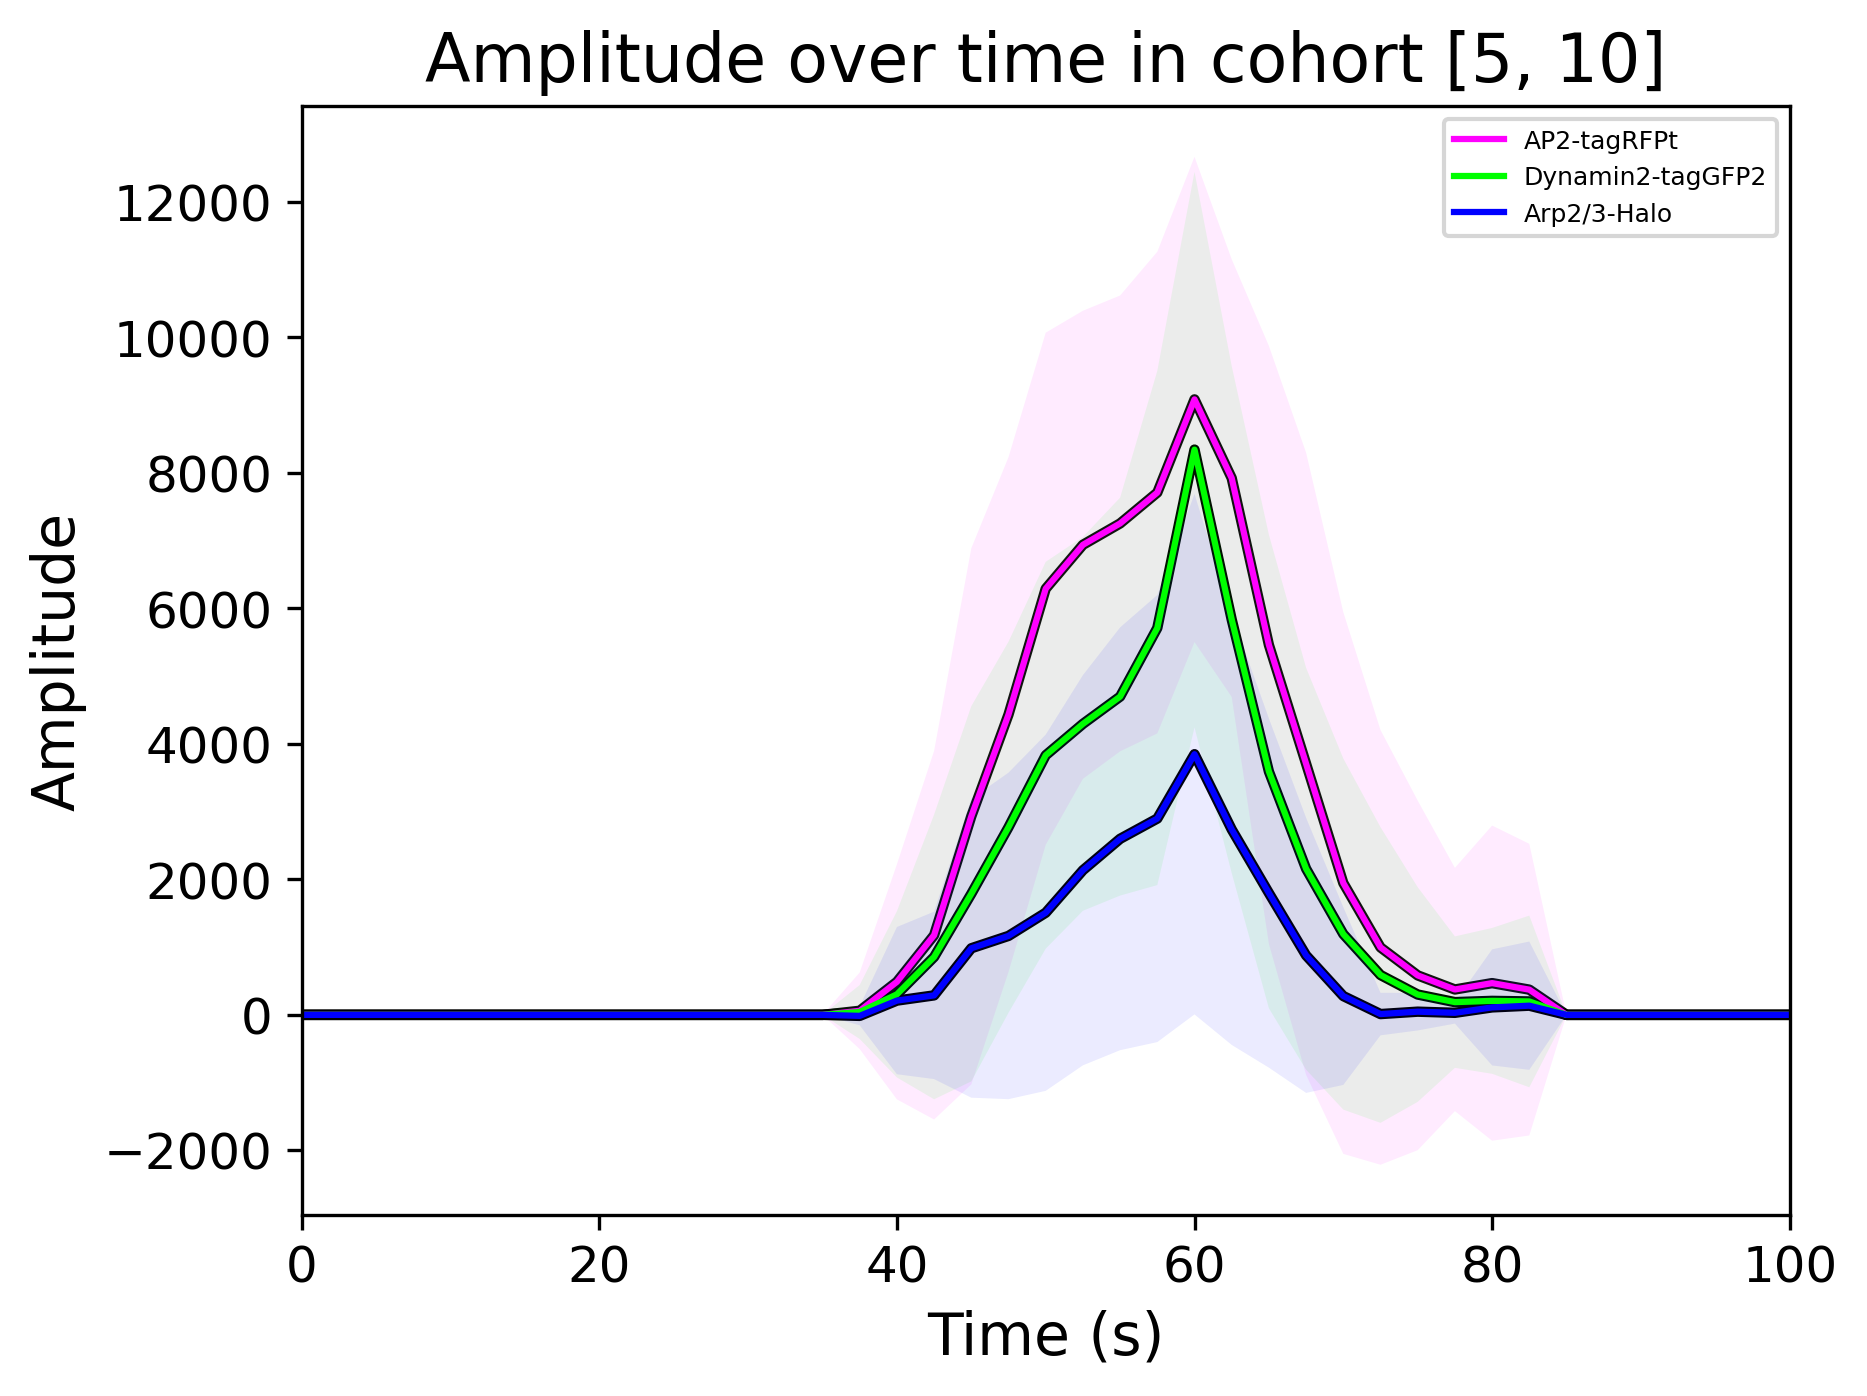

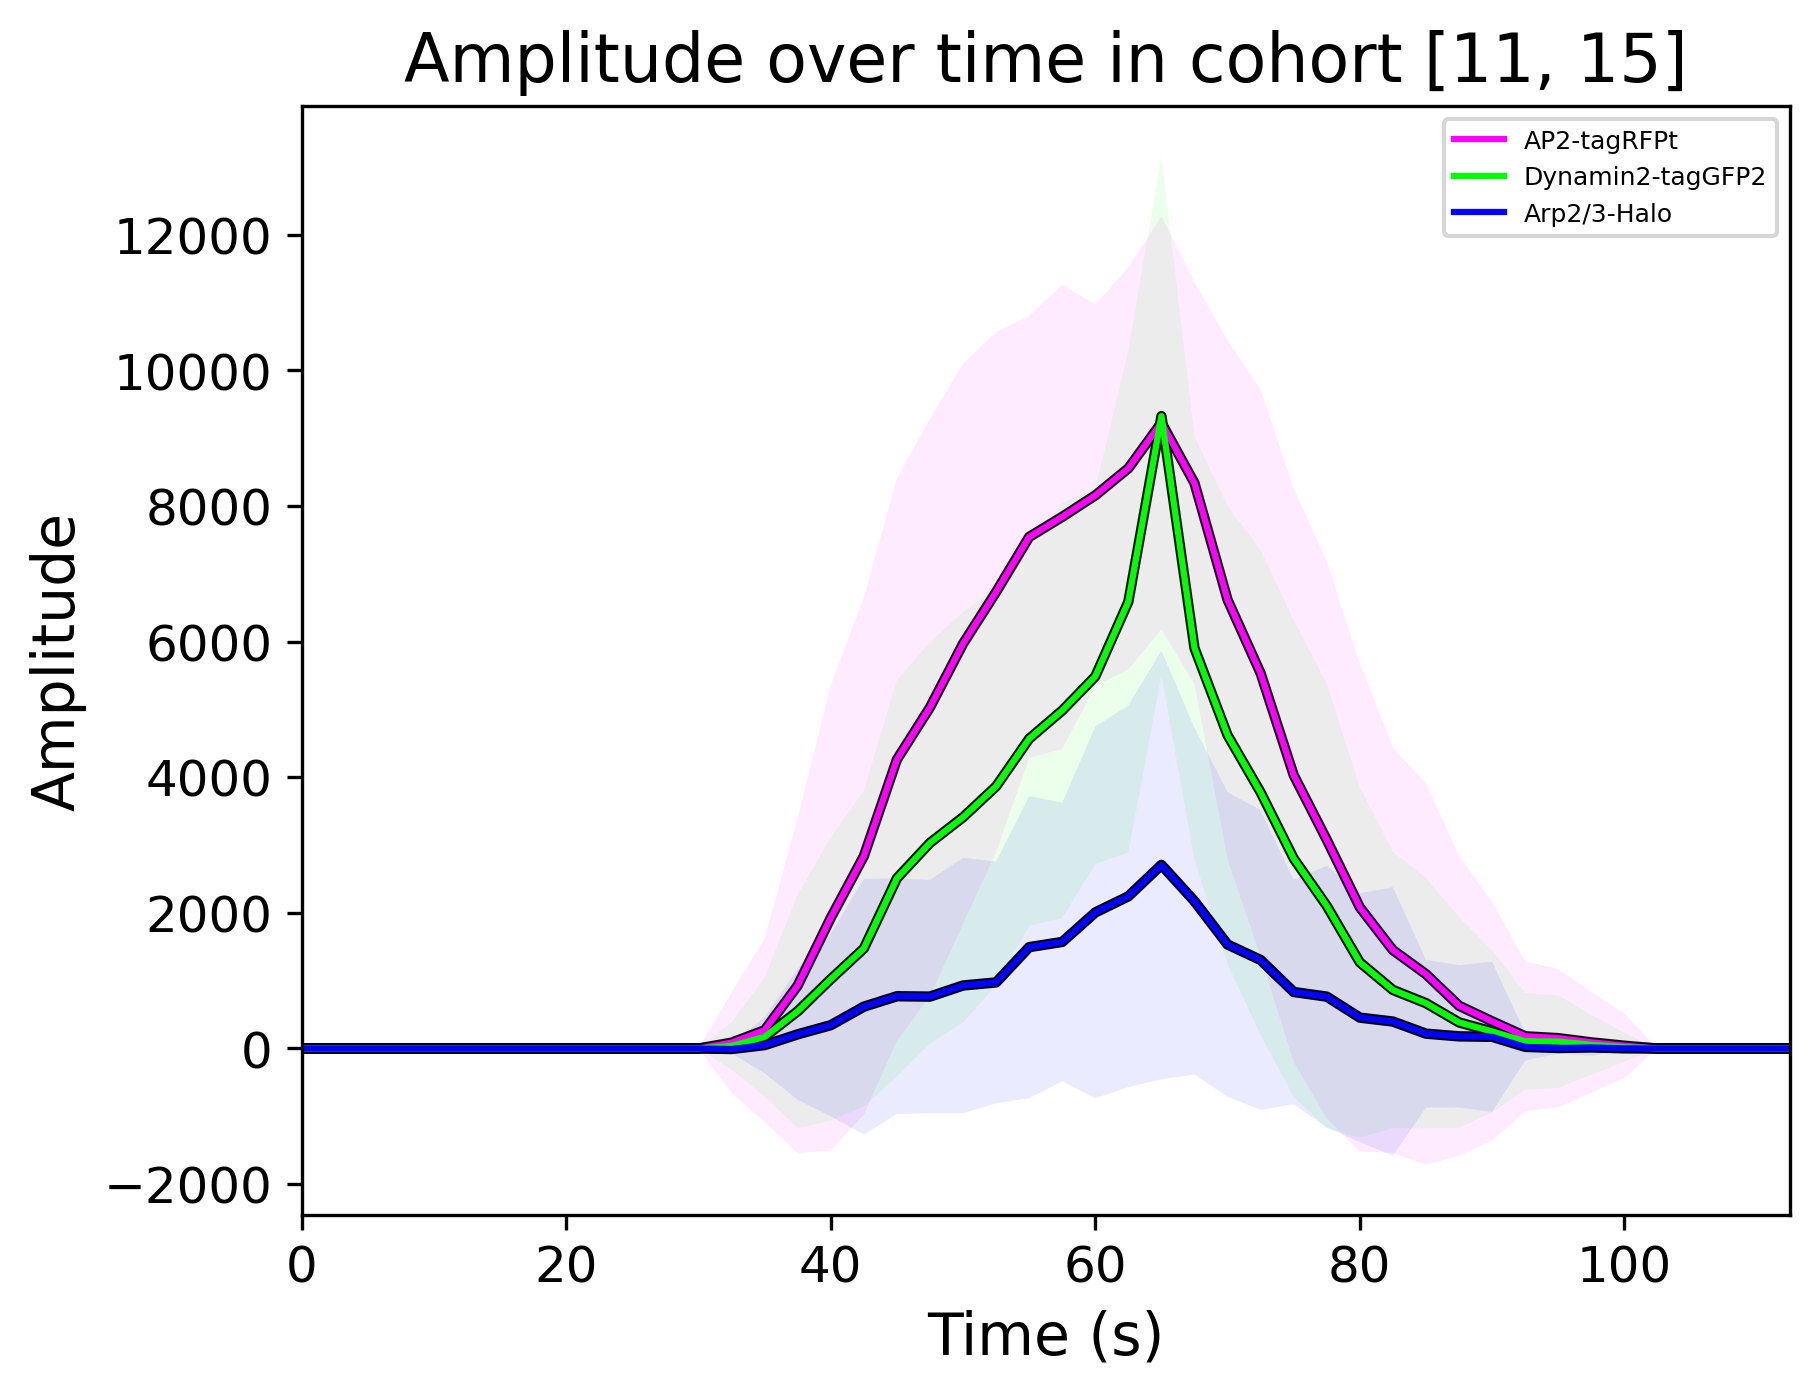

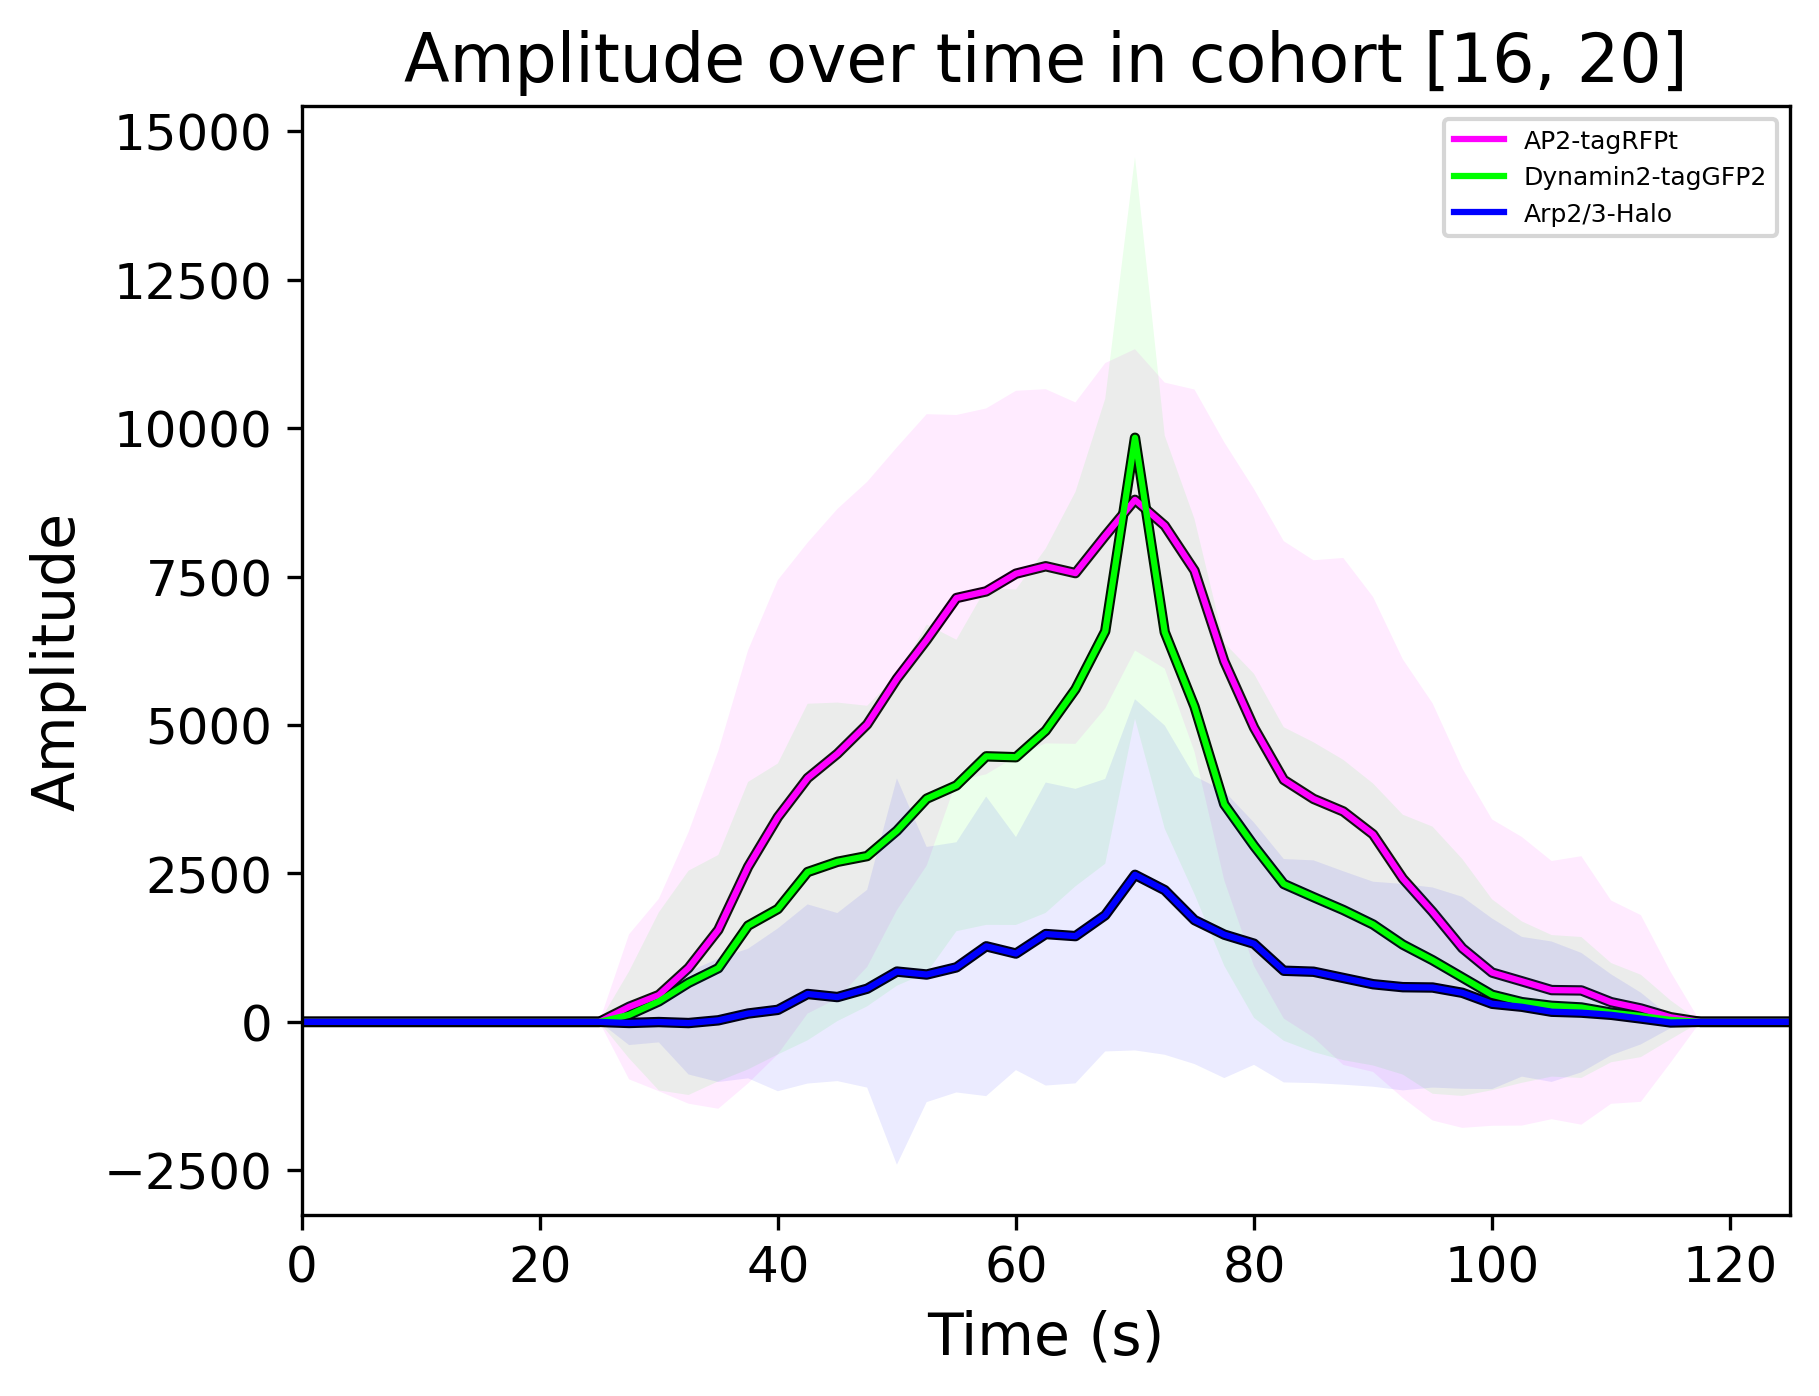

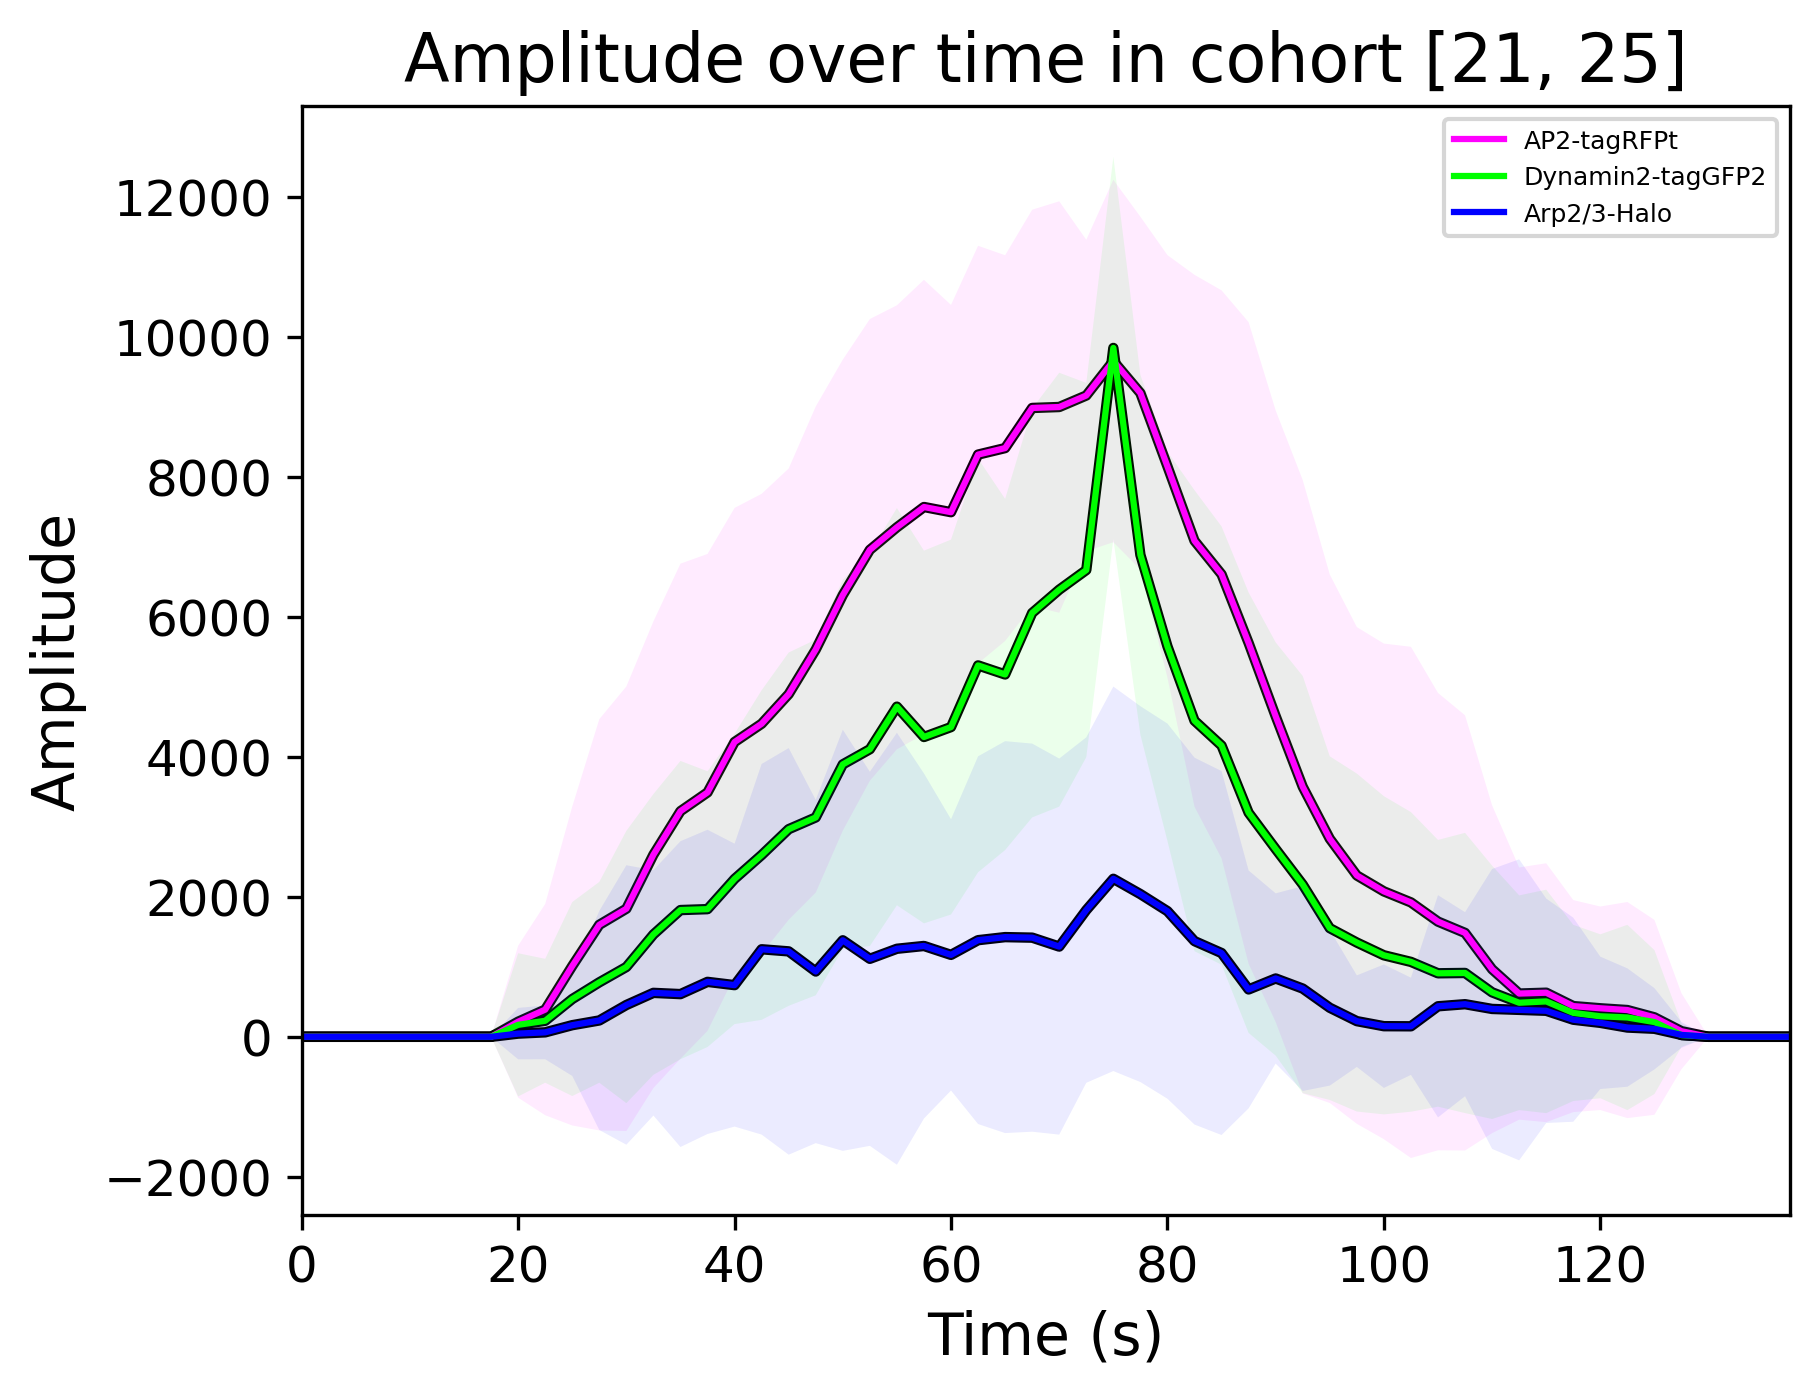

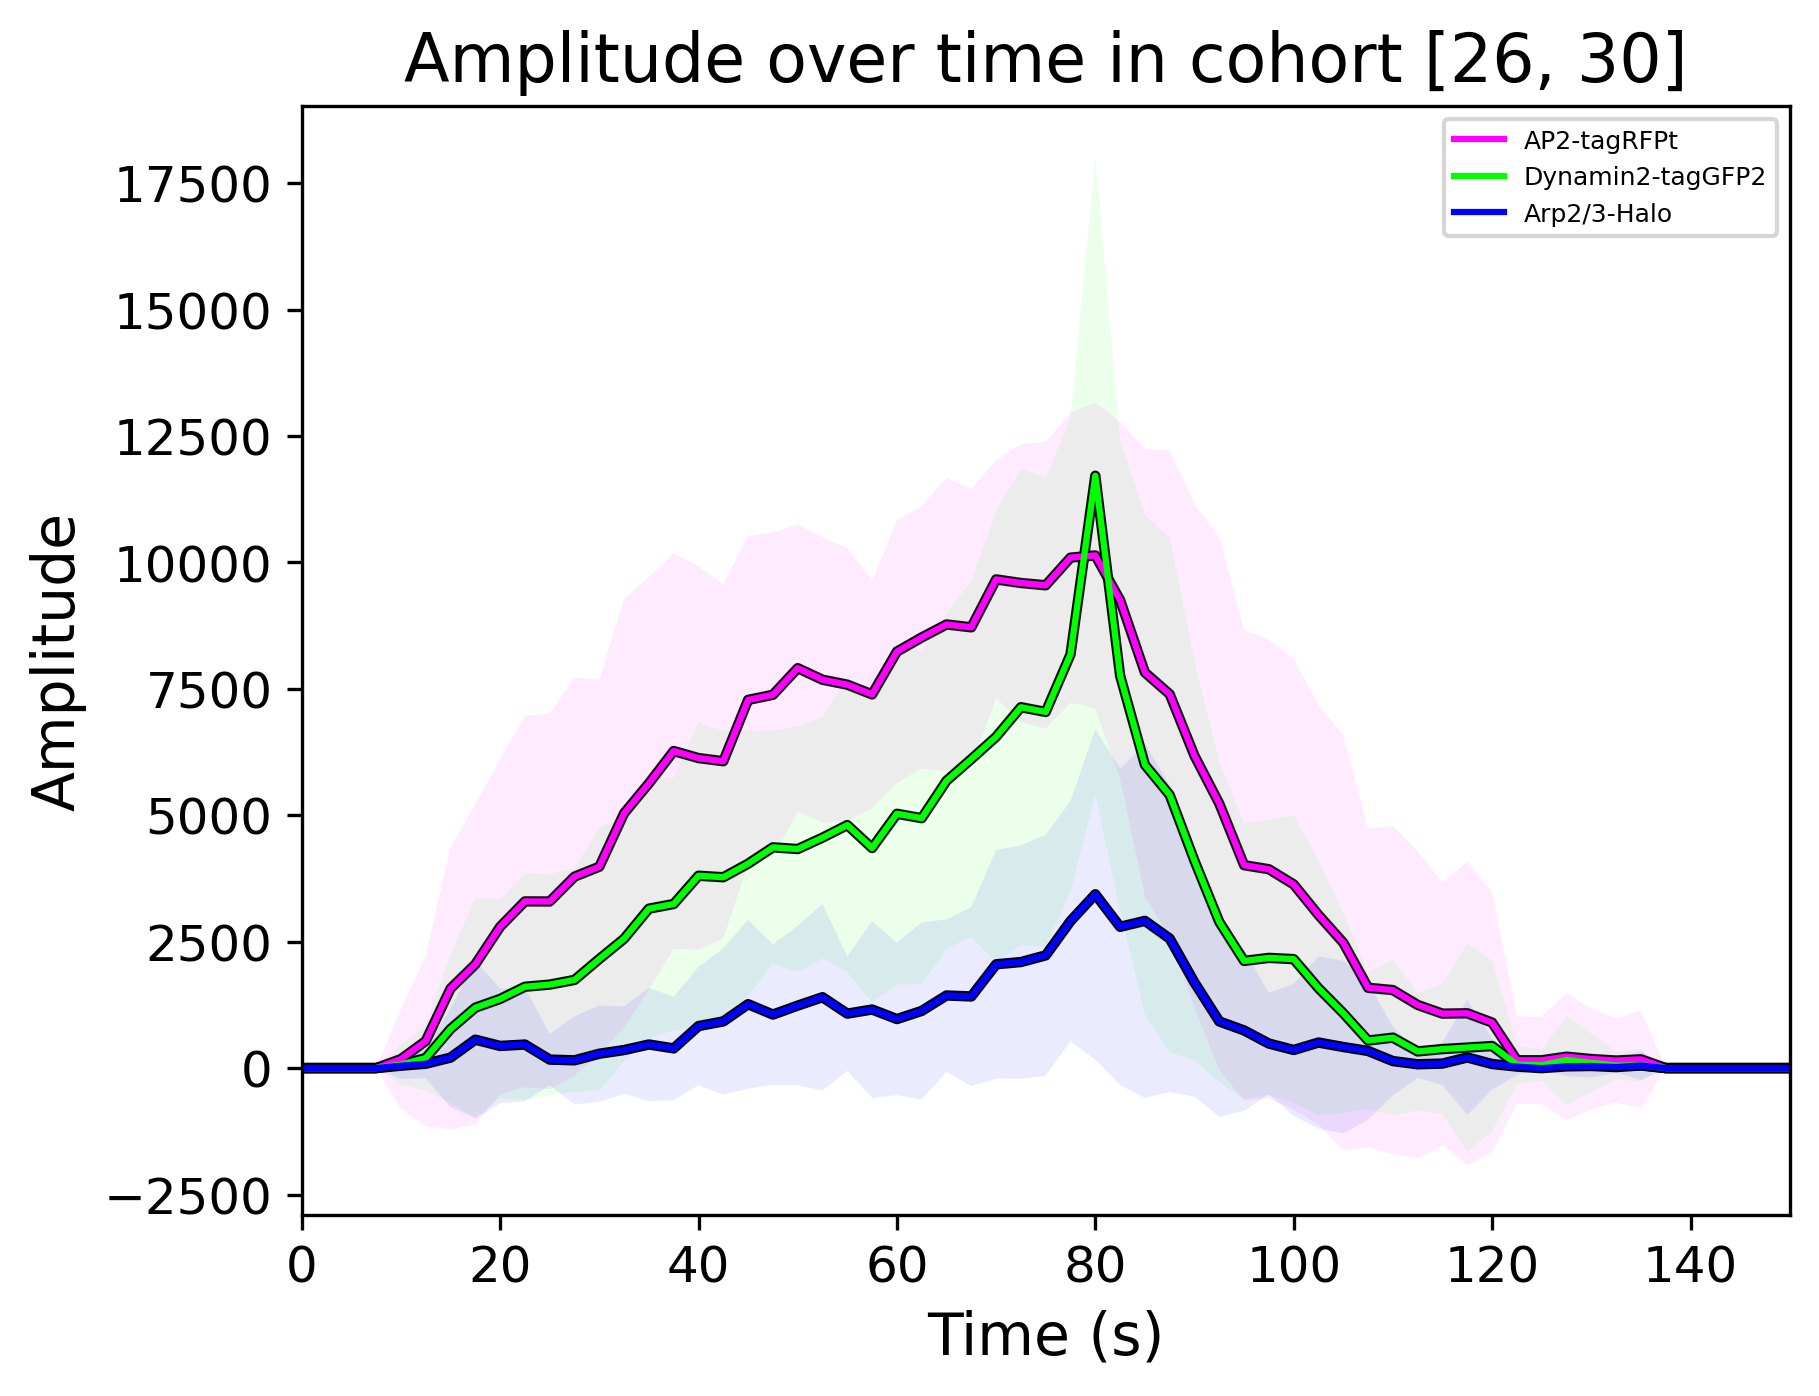

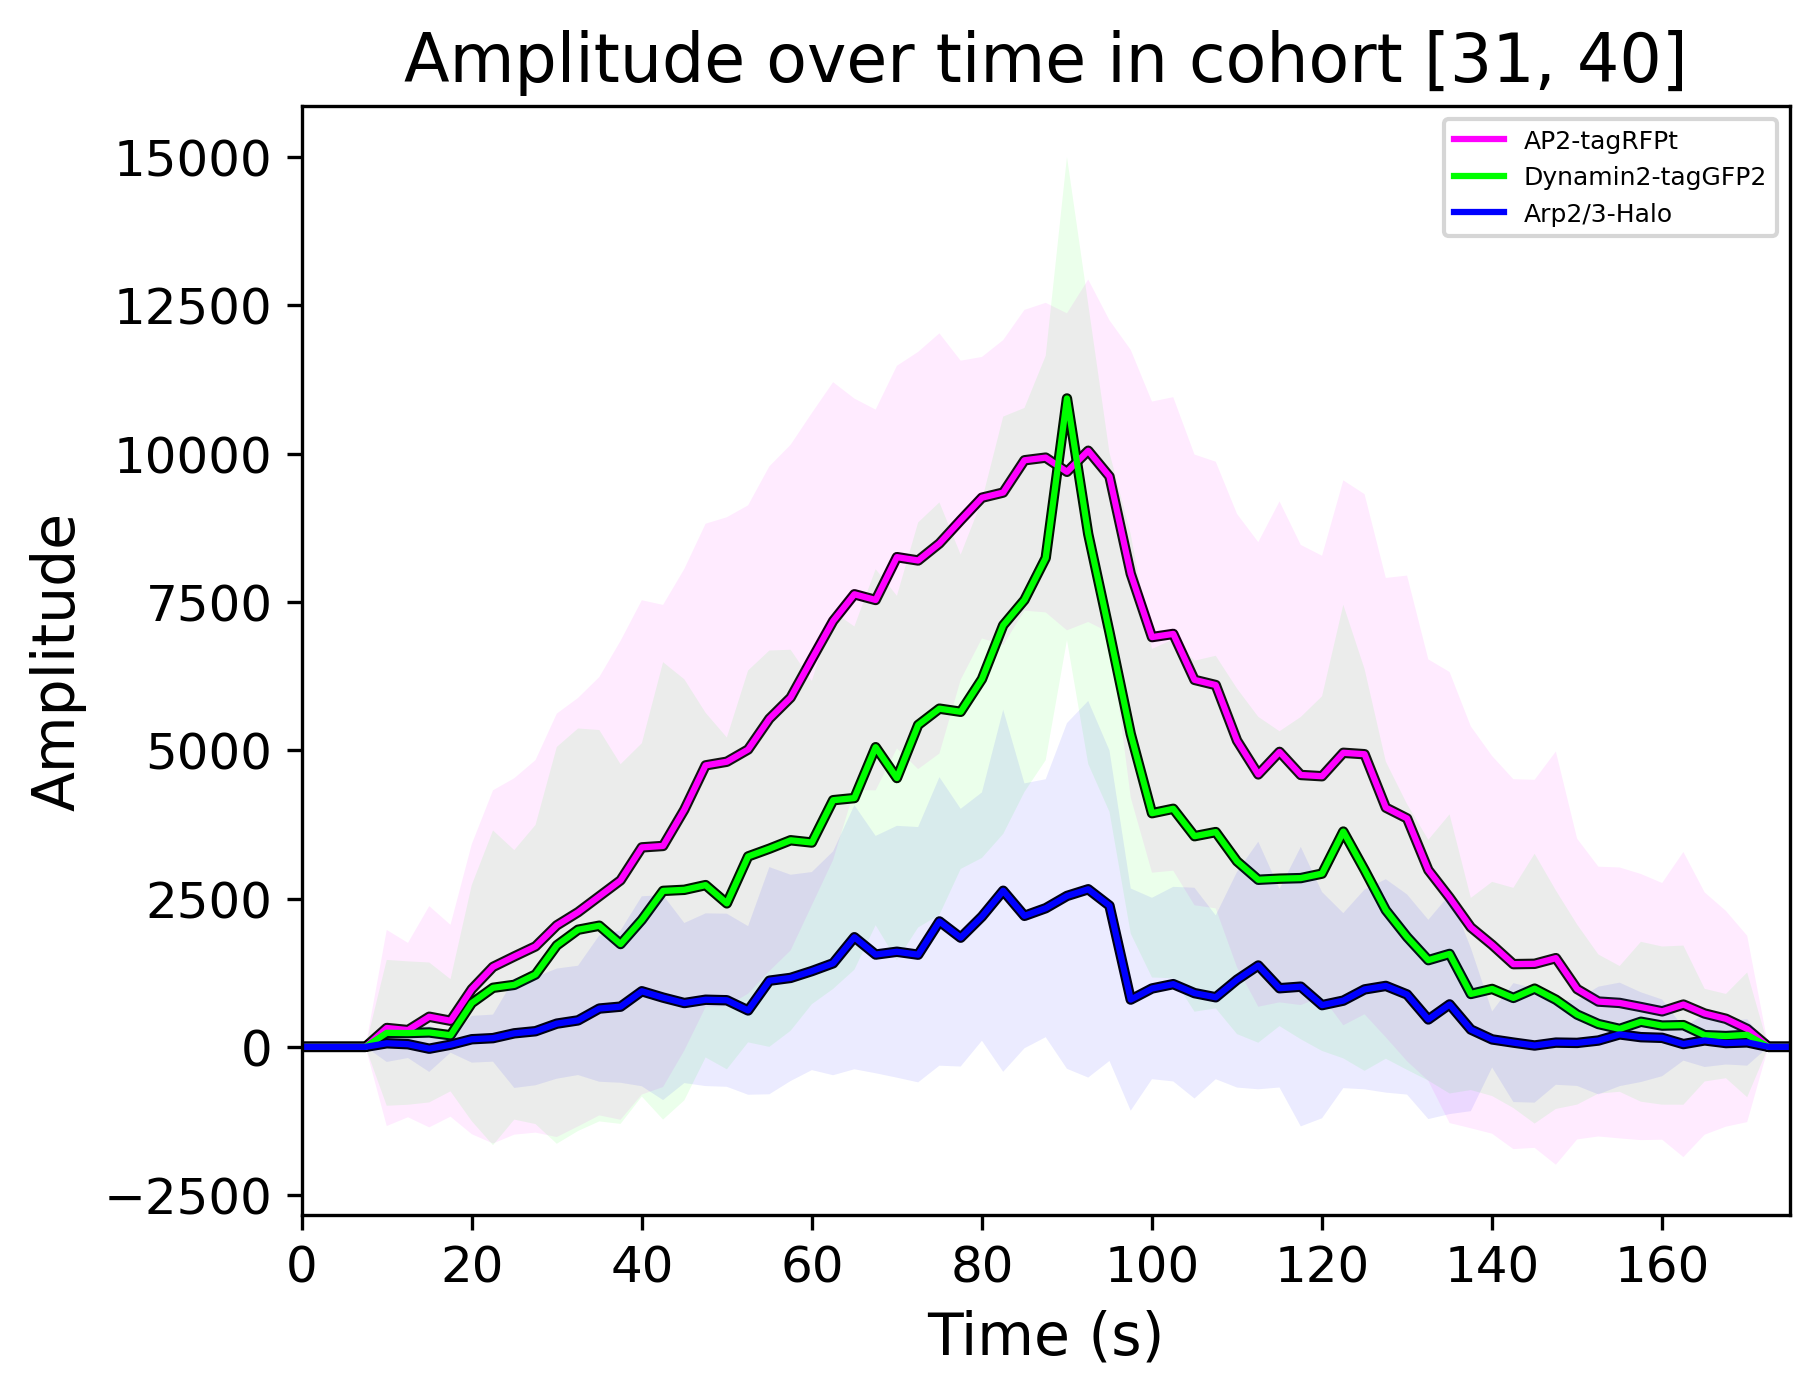

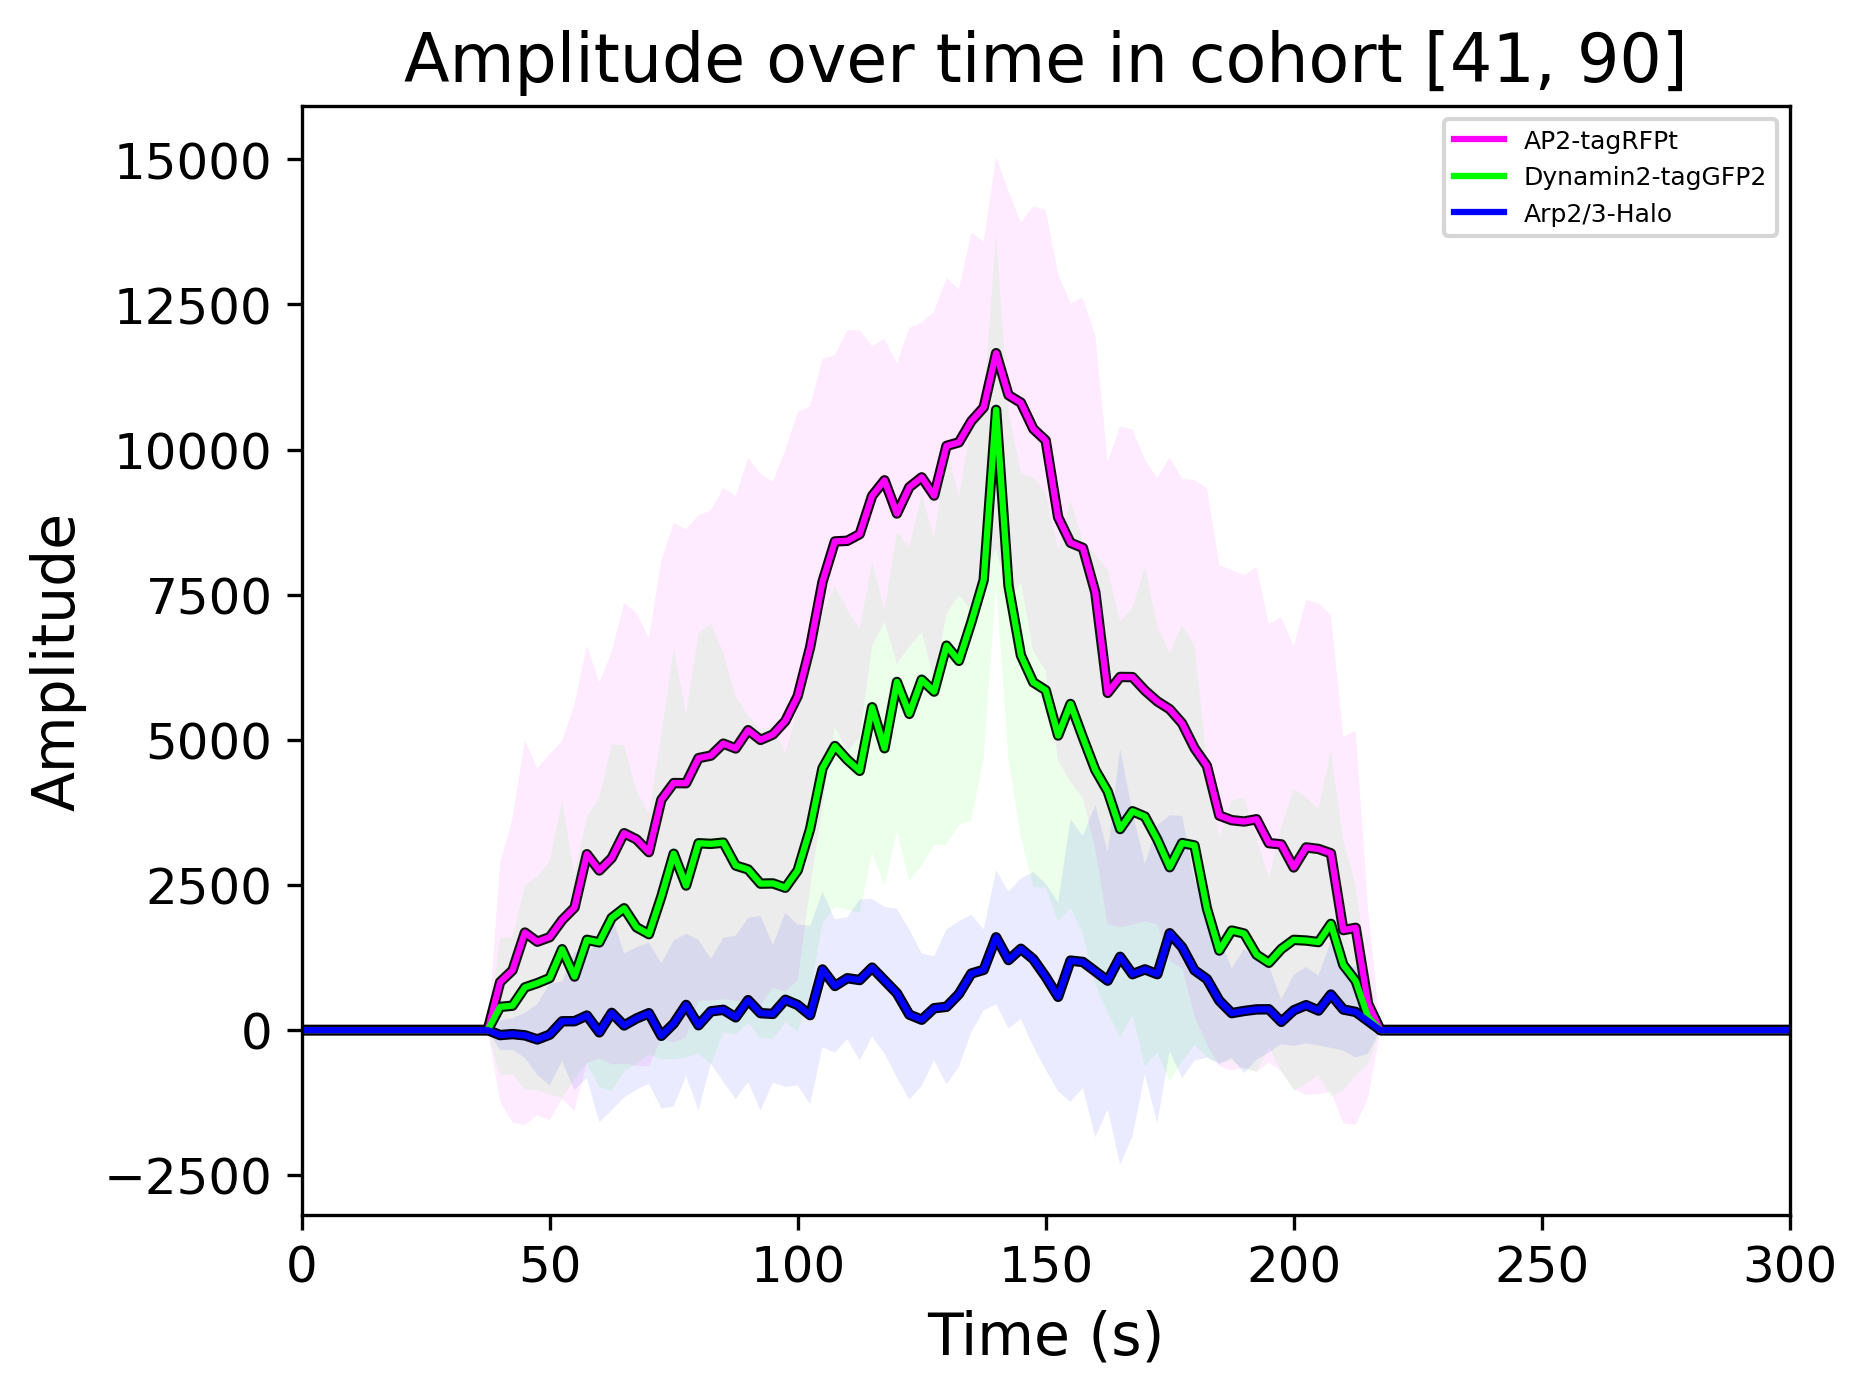

In [20]:
for n, cohort in enumerate(custom_length_ranges):
    primary_buffer, secondary_buffer, tertiary_buffer = createBufferForLifetimeCohort(dataframe = track_df ,
    listOfTrackIdsAssignedToCohort = track_id_arrays[n], backgroundIntensity = [background_channel_3, background_channel_2, background_channel_1],
    intensity_to_plot = [f'c3_{value_to_plot}',f'c2_{value_to_plot}', f'c1_{value_to_plot}'], track_id_col_name = 'track_id')

    cumulative_plots(buffers = [primary_buffer, secondary_buffer, tertiary_buffer],
    background_intensity= [background_channel_3, background_channel_2, background_channel_1], time_shift = 50+cohort[1], framerate_msec = framerate_msec, colors = ['magenta', 'lime', 'blue'], 
                    legend_vals = [channel3_name, channel2_name, channel1_name])
    plt.xlim(0, 75+cohort[1]*framerate_msec/1000)
    # plt.xlim(35, 85)

    plt.title(f'Amplitude over time in cohort {custom_length_ranges[n]}', fontsize=16)
    plt.xlabel('Time (s)', fontsize=14)
    plt.ylabel('Amplitude', fontsize=14)
    # increase tick sizes
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()


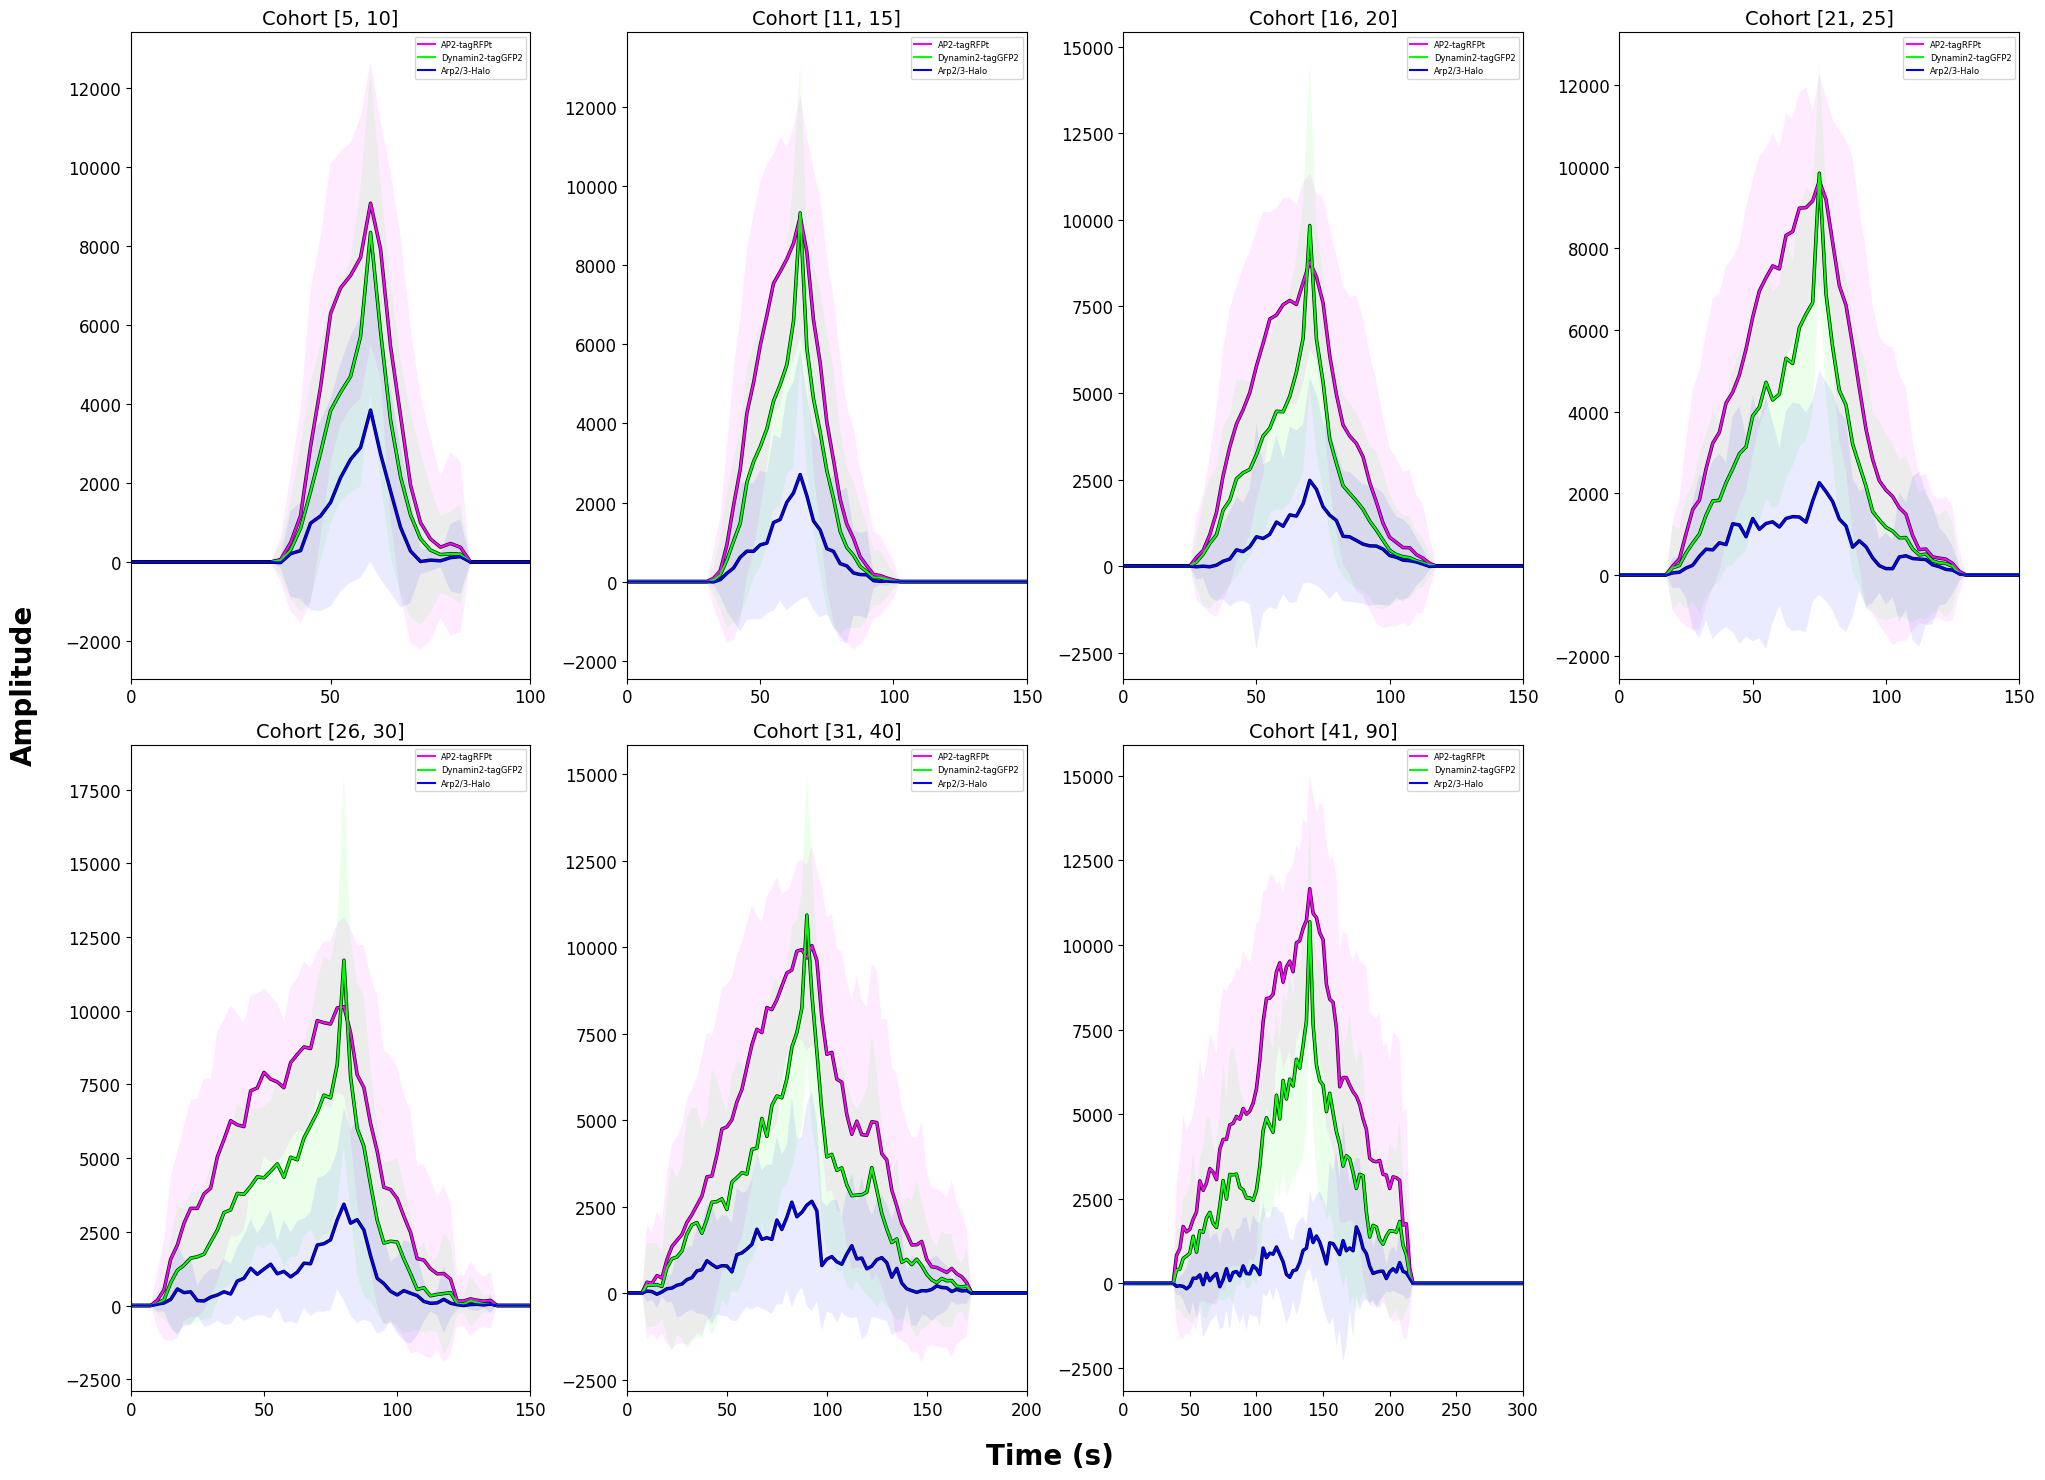

In [31]:
import matplotlib.pyplot as plt

# Create a figure with 2 rows and 4 columns (giving space for 8 plots)
fig, axes = plt.subplots(2, 4, figsize=(20, 15))  # 2 rows, 4 columns (adjust figsize as needed)
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

# Loop through cohorts and plot on the subplots
for n, cohort in enumerate(custom_length_ranges):
    # Assuming buffers and other variables are defined
    primary_buffer, secondary_buffer, tertiary_buffer = createBufferForLifetimeCohort(
        dataframe=track_df,
        listOfTrackIdsAssignedToCohort=track_id_arrays[n],
        backgroundIntensity=[background_channel_3, background_channel_2, background_channel_1],
        intensity_to_plot=[f'c3_{value_to_plot}', f'c2_{value_to_plot}', f'c1_{value_to_plot}'],
        track_id_col_name='track_id'
    )
    
    # Get the appropriate axis from the axes array
    ax = axes[n]
    
    # Call cumulative_plots and pass the axis for the current subplot
    cumulative_plots_ax(
        buffers=[primary_buffer, secondary_buffer, tertiary_buffer],
        background_intensity=[background_channel_3, background_channel_2, background_channel_1],
        time_shift=50 + cohort[1],  # Adjust time shift as necessary
        framerate_msec=framerate_msec,
        colors=['magenta', 'lime', 'blue'],
        legend_vals=[channel3_name, channel2_name, channel1_name],
        ax=ax  # Pass the axis of the current subplot
    )

    # Set the x-axis limits for each subplot
    x_min = 0
    x_max = 75 + cohort[1] * framerate_msec / 1000
    ax.set_xlim(x_min, x_max)
    
    # Set x-axis ticks at intervals of 50
    ax.set_xticks(np.arange(x_min, x_max + 50, 50))
    
    # Set the title for each subplot
    ax.set_title(f'Cohort {custom_length_ranges[n]}', fontsize=14)
    
    # Remove gridlines
    ax.grid(False)
    
    # Customize the x and y ticks (optional)
    ax.tick_params(axis='both', labelsize=12)

# Hide any unused subplots (since you only have 7 cohorts)
for i in range(7, len(axes)):
    axes[i].axis('off')  # Turn off the axis for unused subplots

# Set shared x and y labels for the entire figure
fig.text(0.5, -0.02, 'Time (s)', ha='center', fontsize=20, weight = 'bold')  # Shared x label
fig.text(-0.02, 0.5, 'Amplitude', va='center', rotation='vertical', fontsize=20, weight = 'bold')  # Shared y label


# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust tight layout to leave space for shared labels

# Show the plot
plt.show()

Normalized

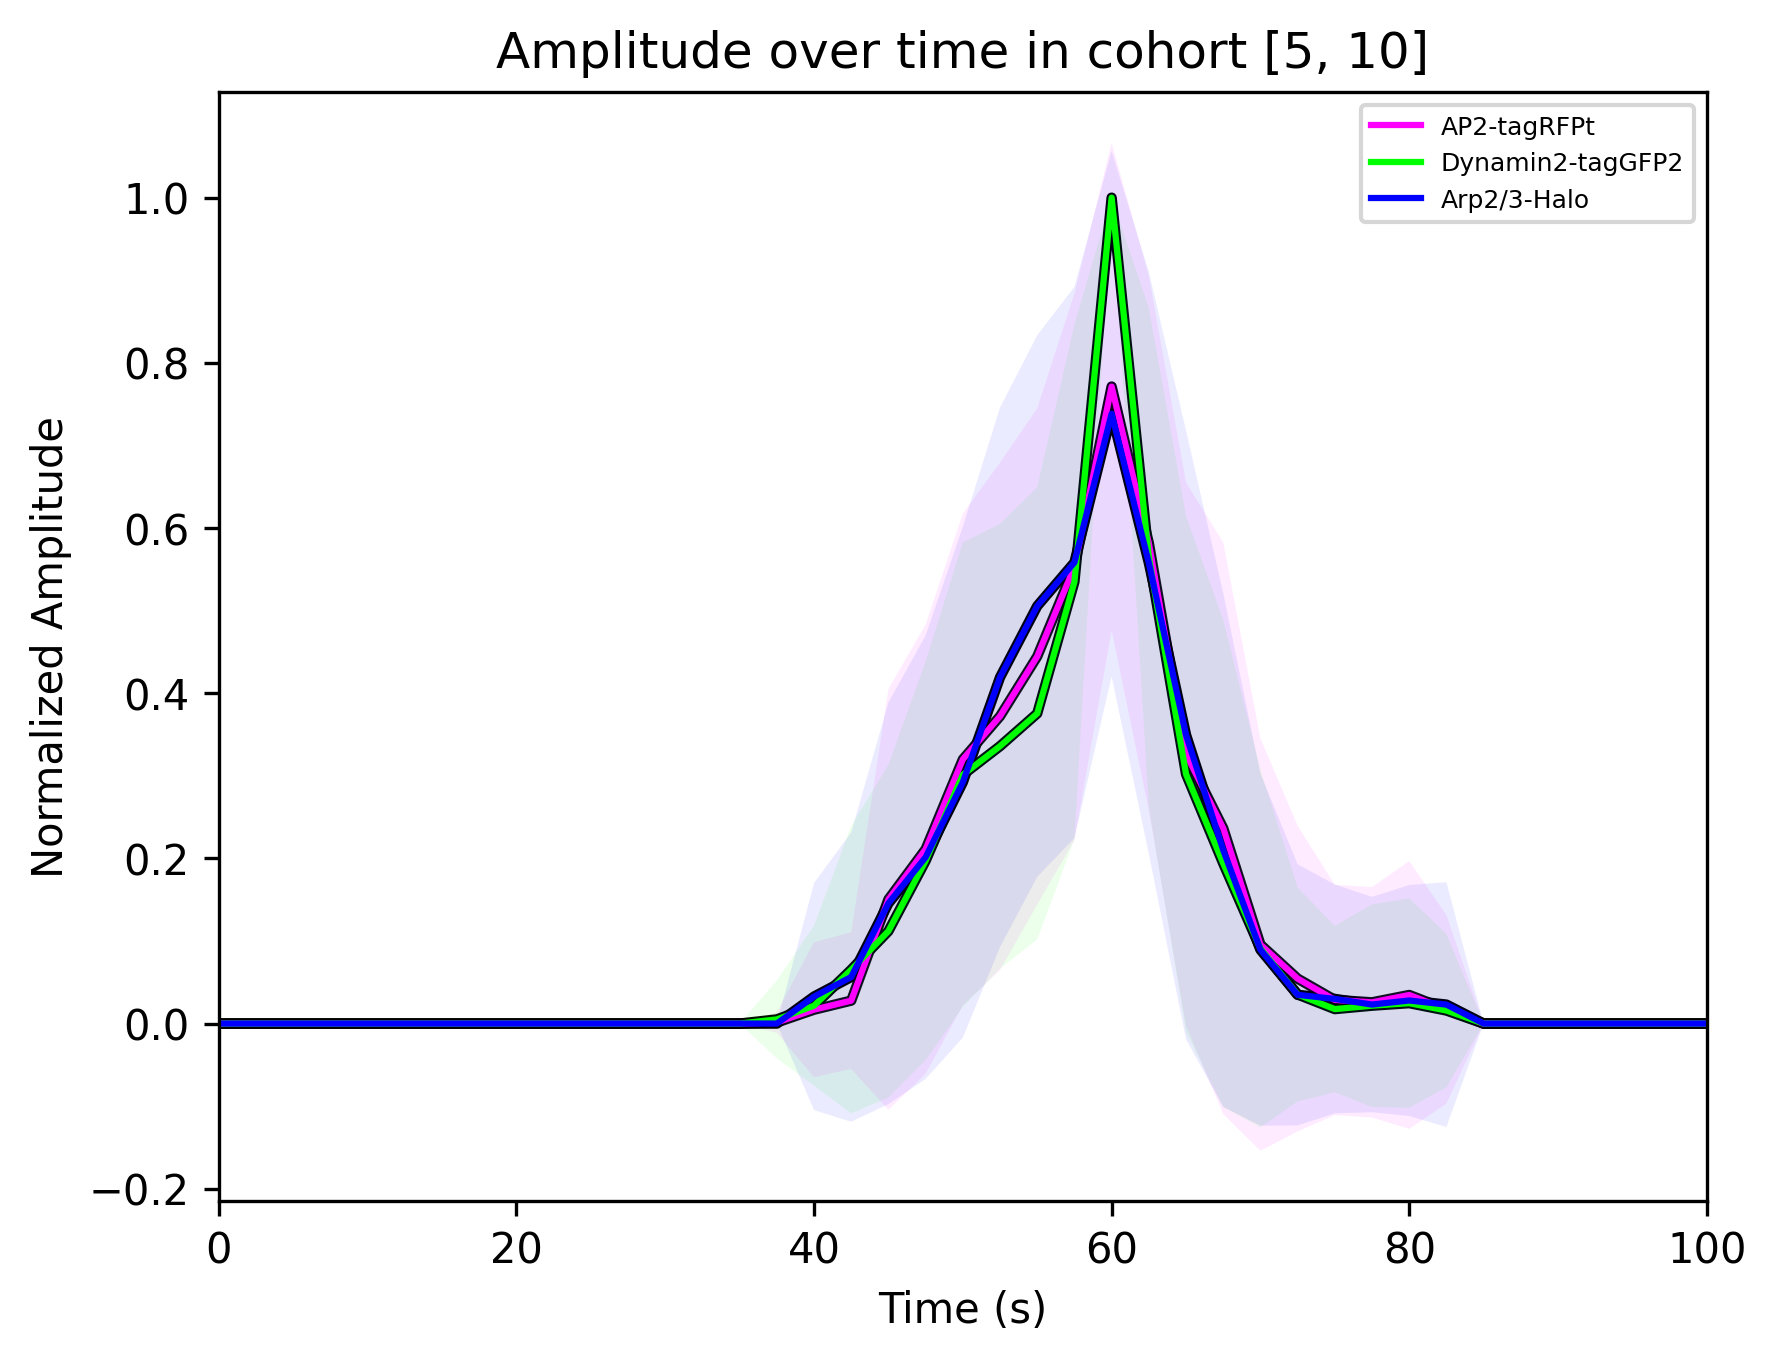

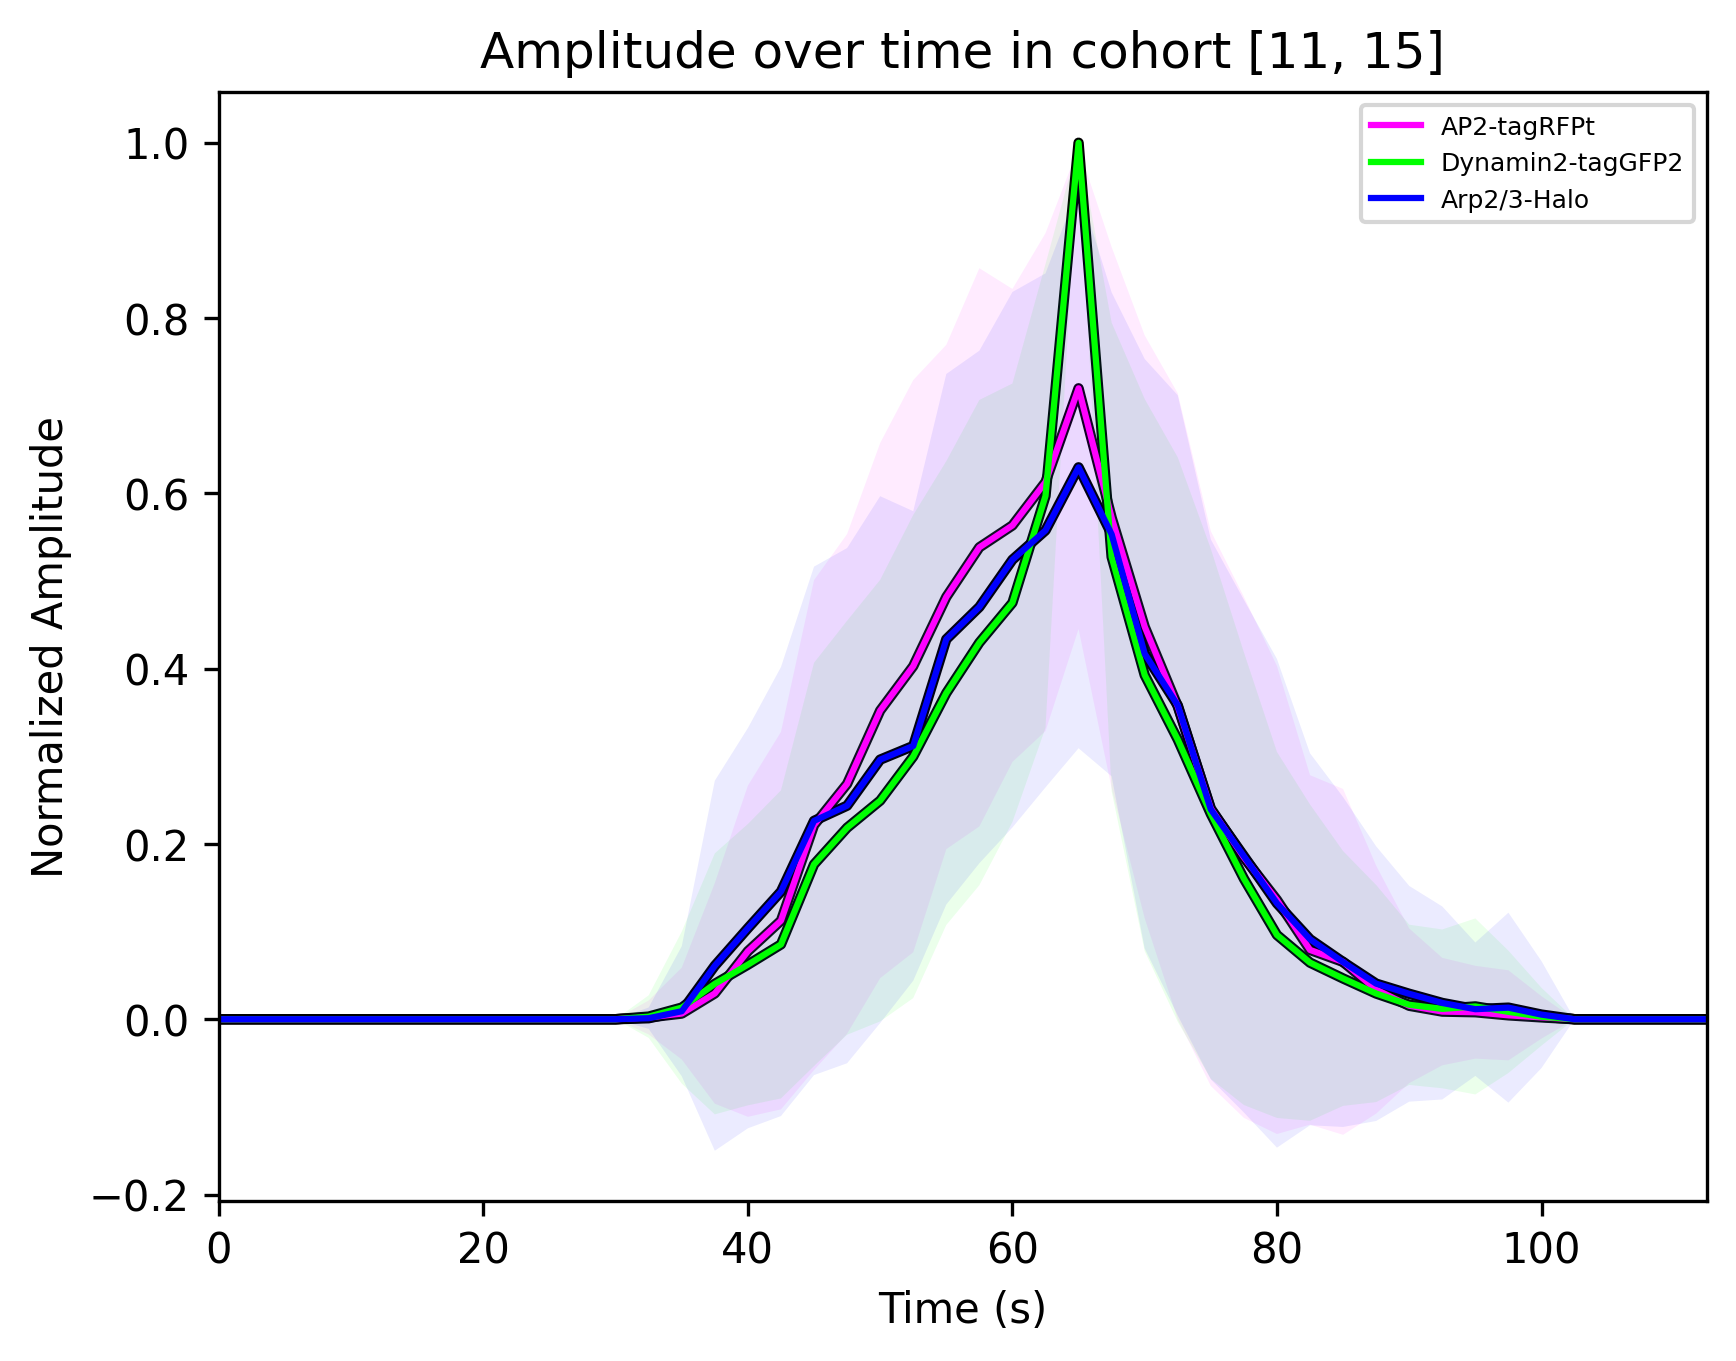

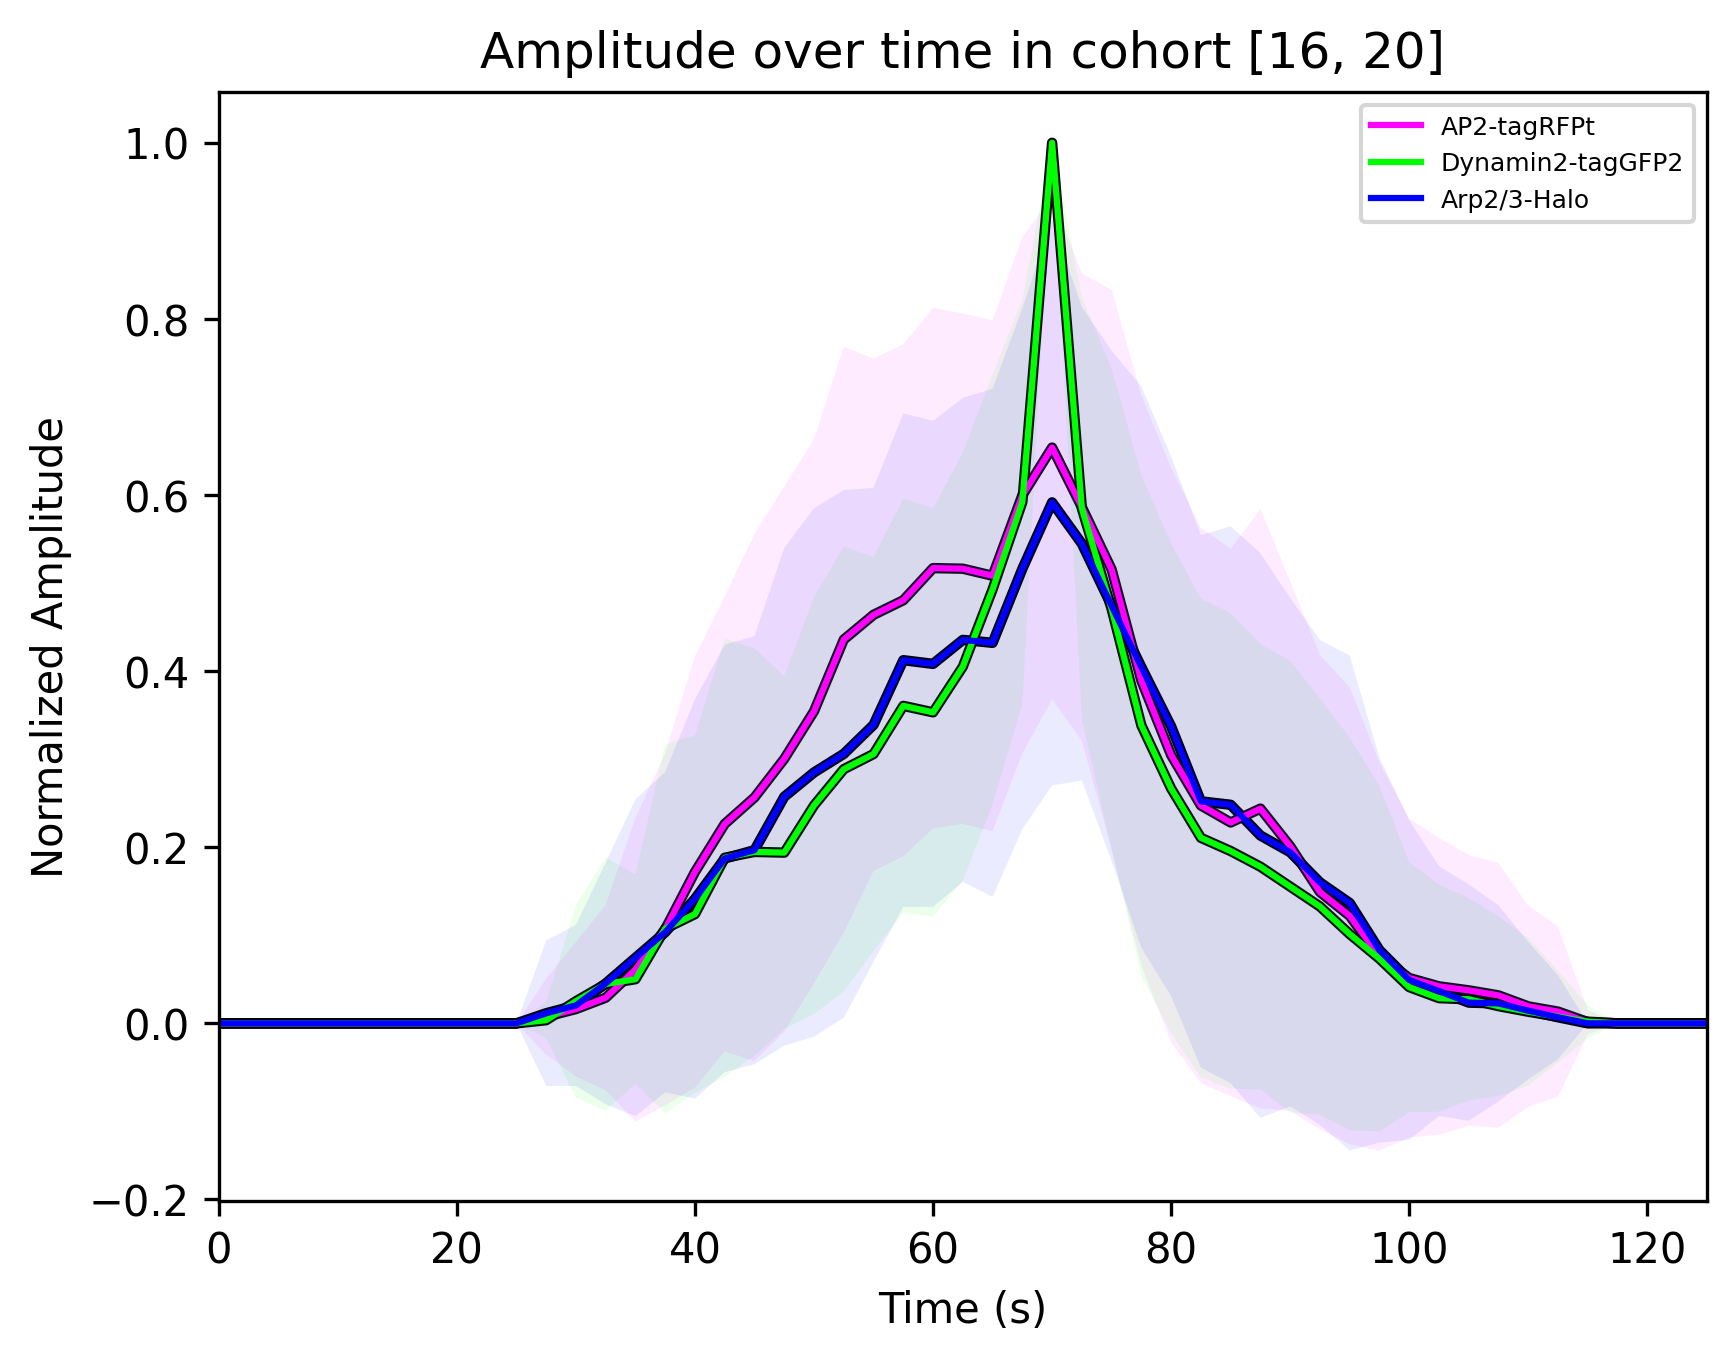

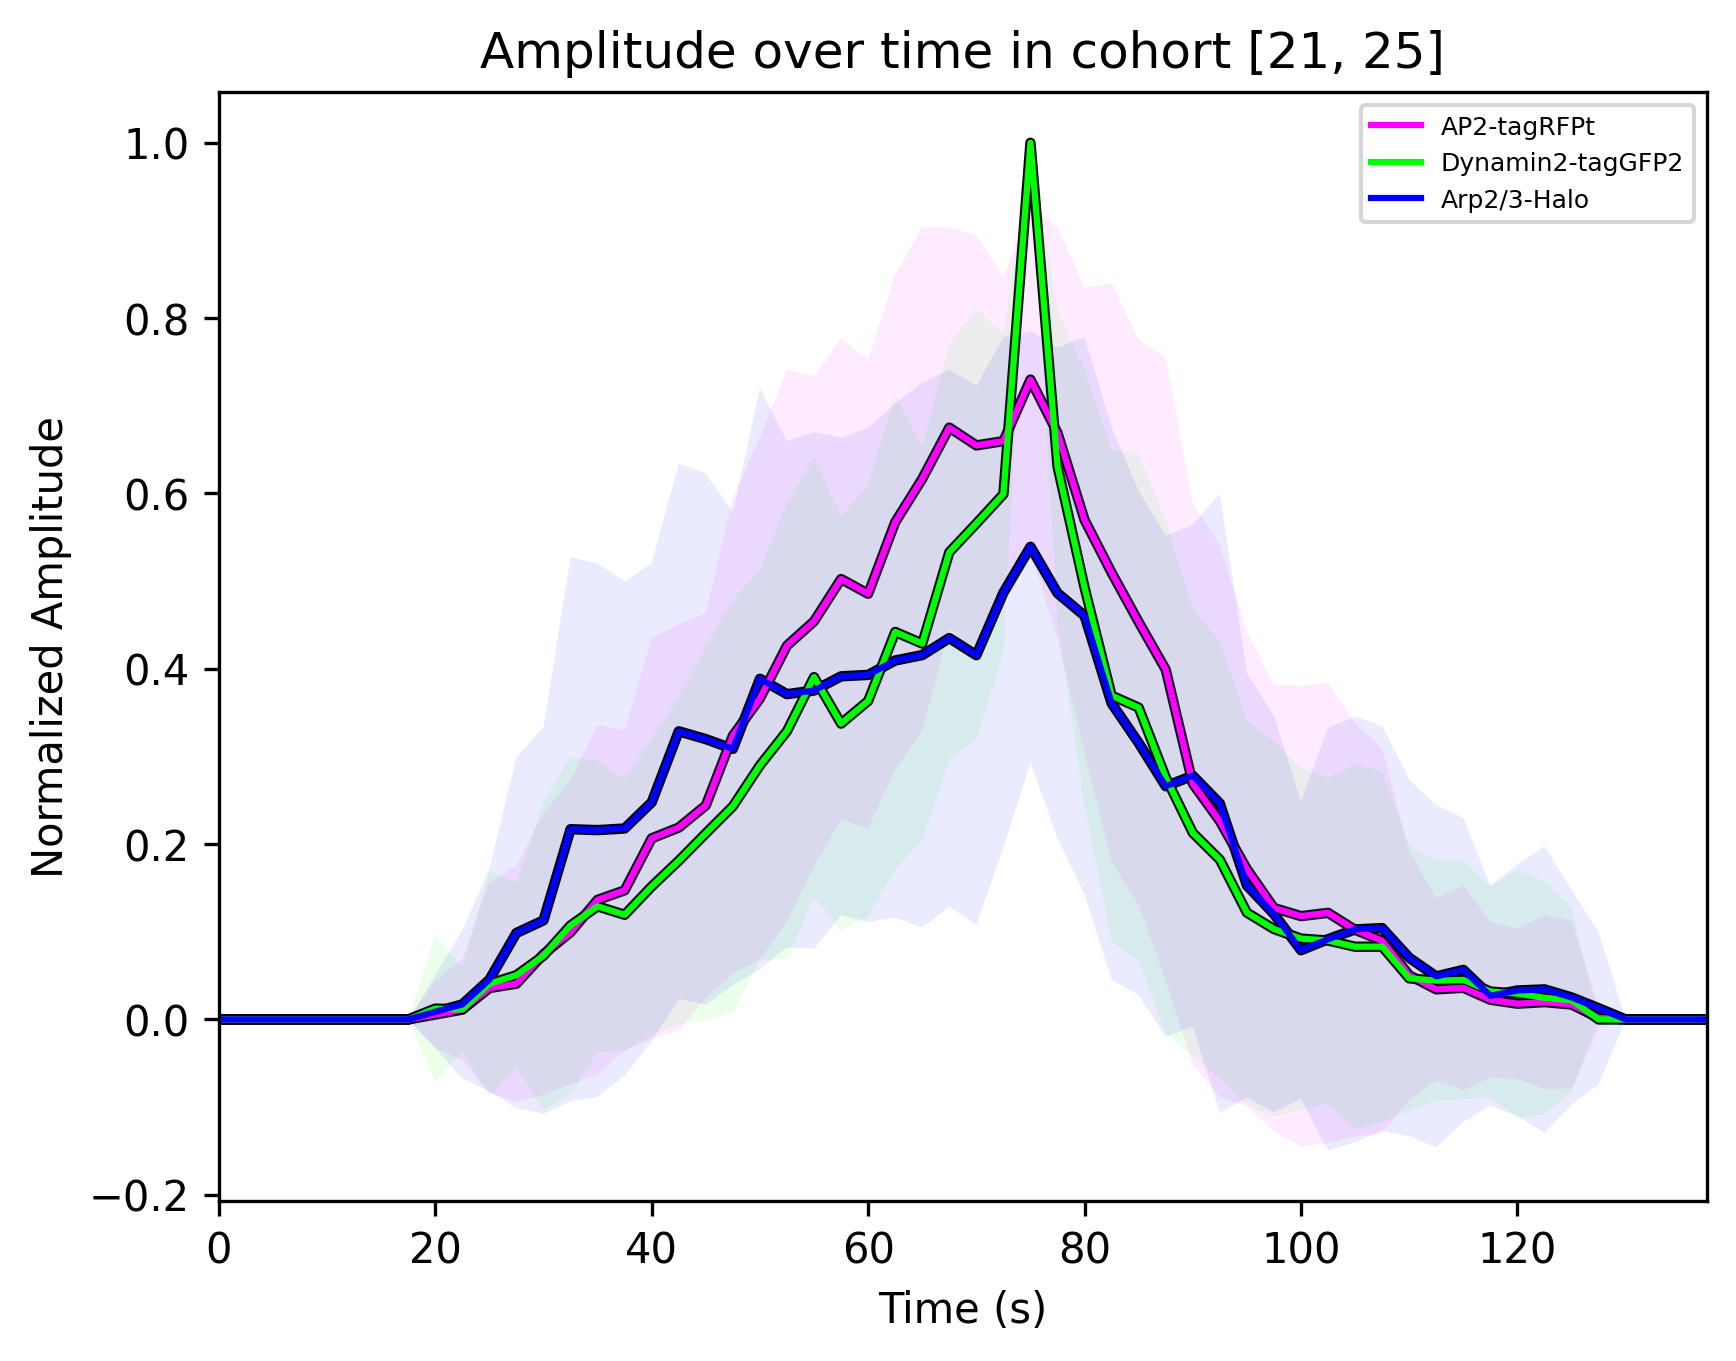

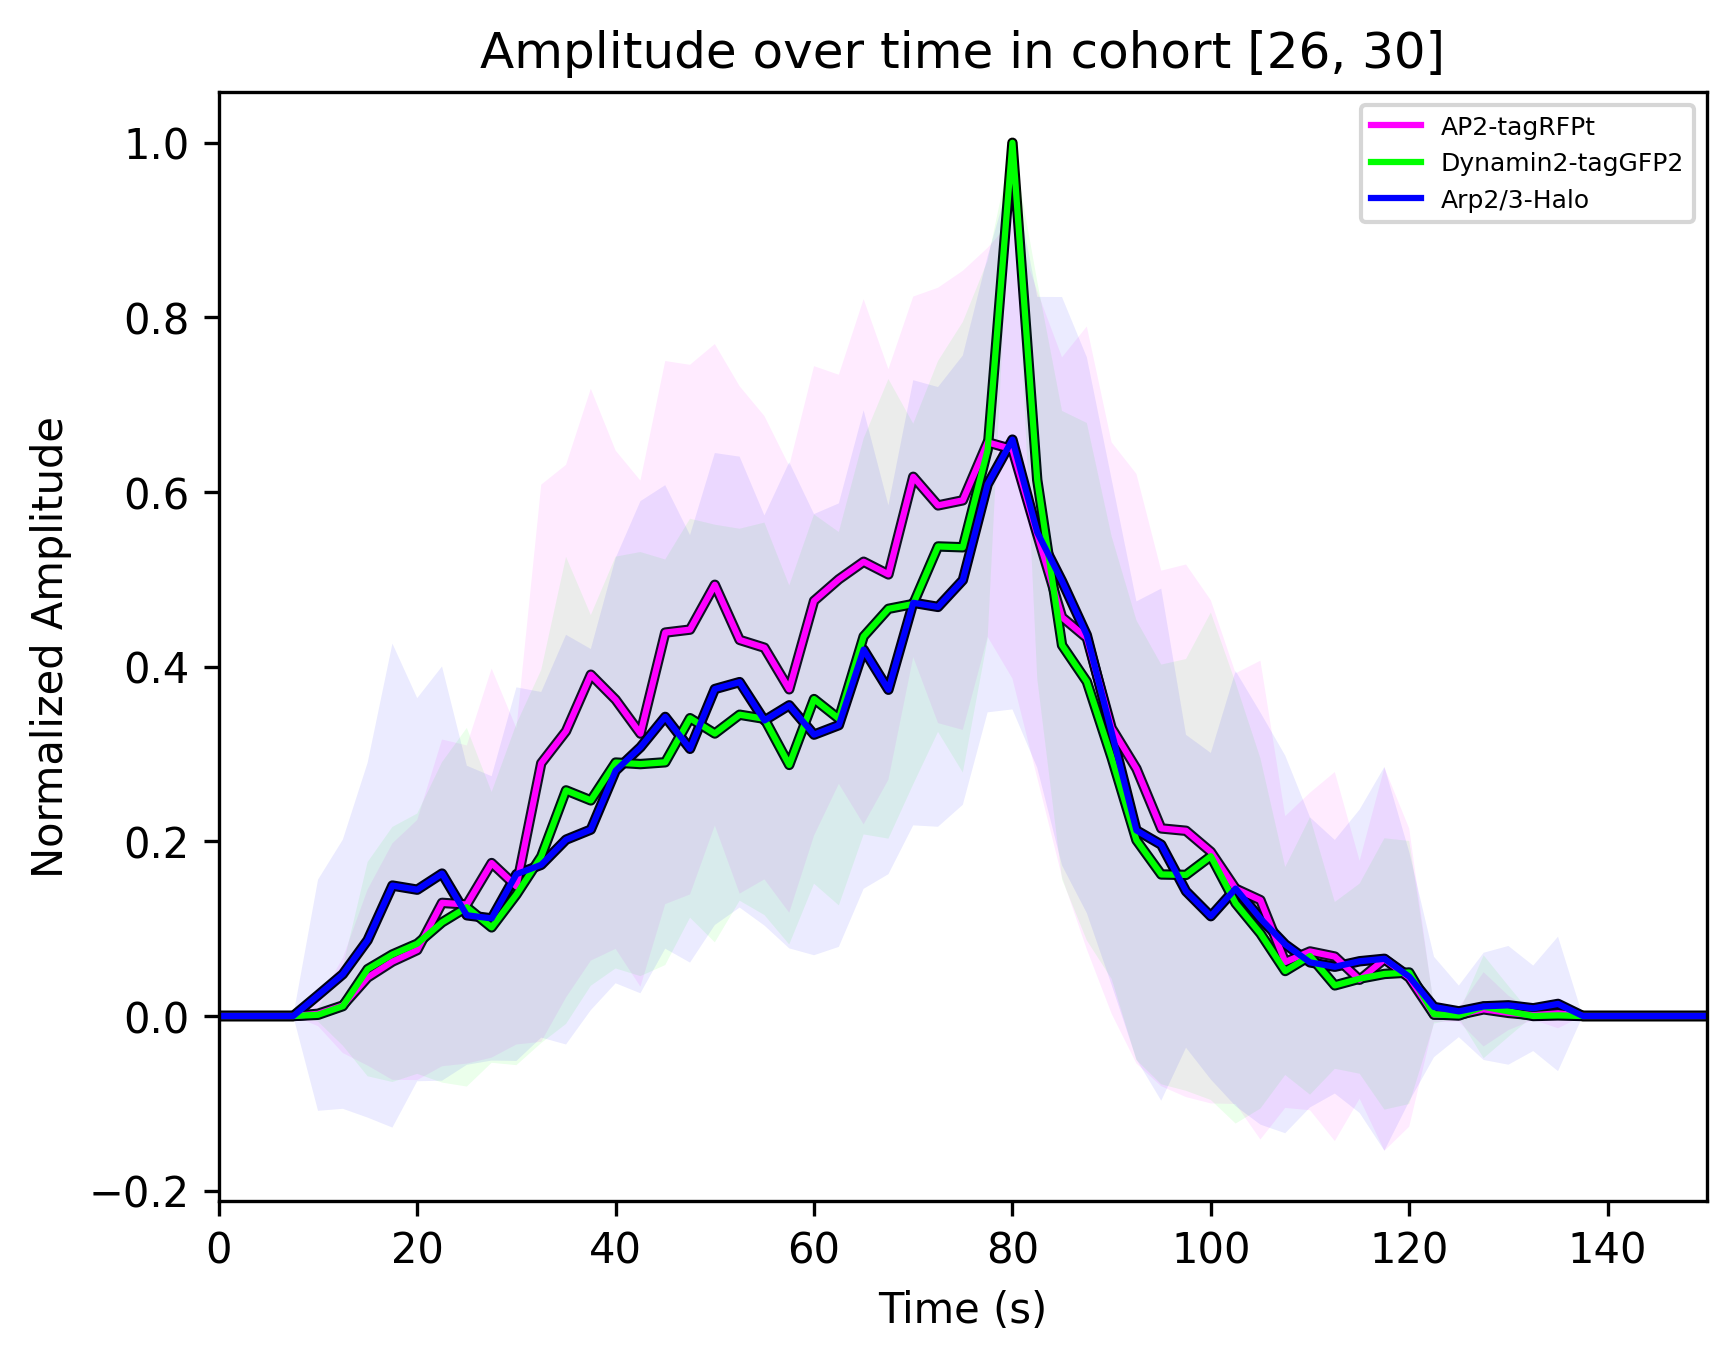

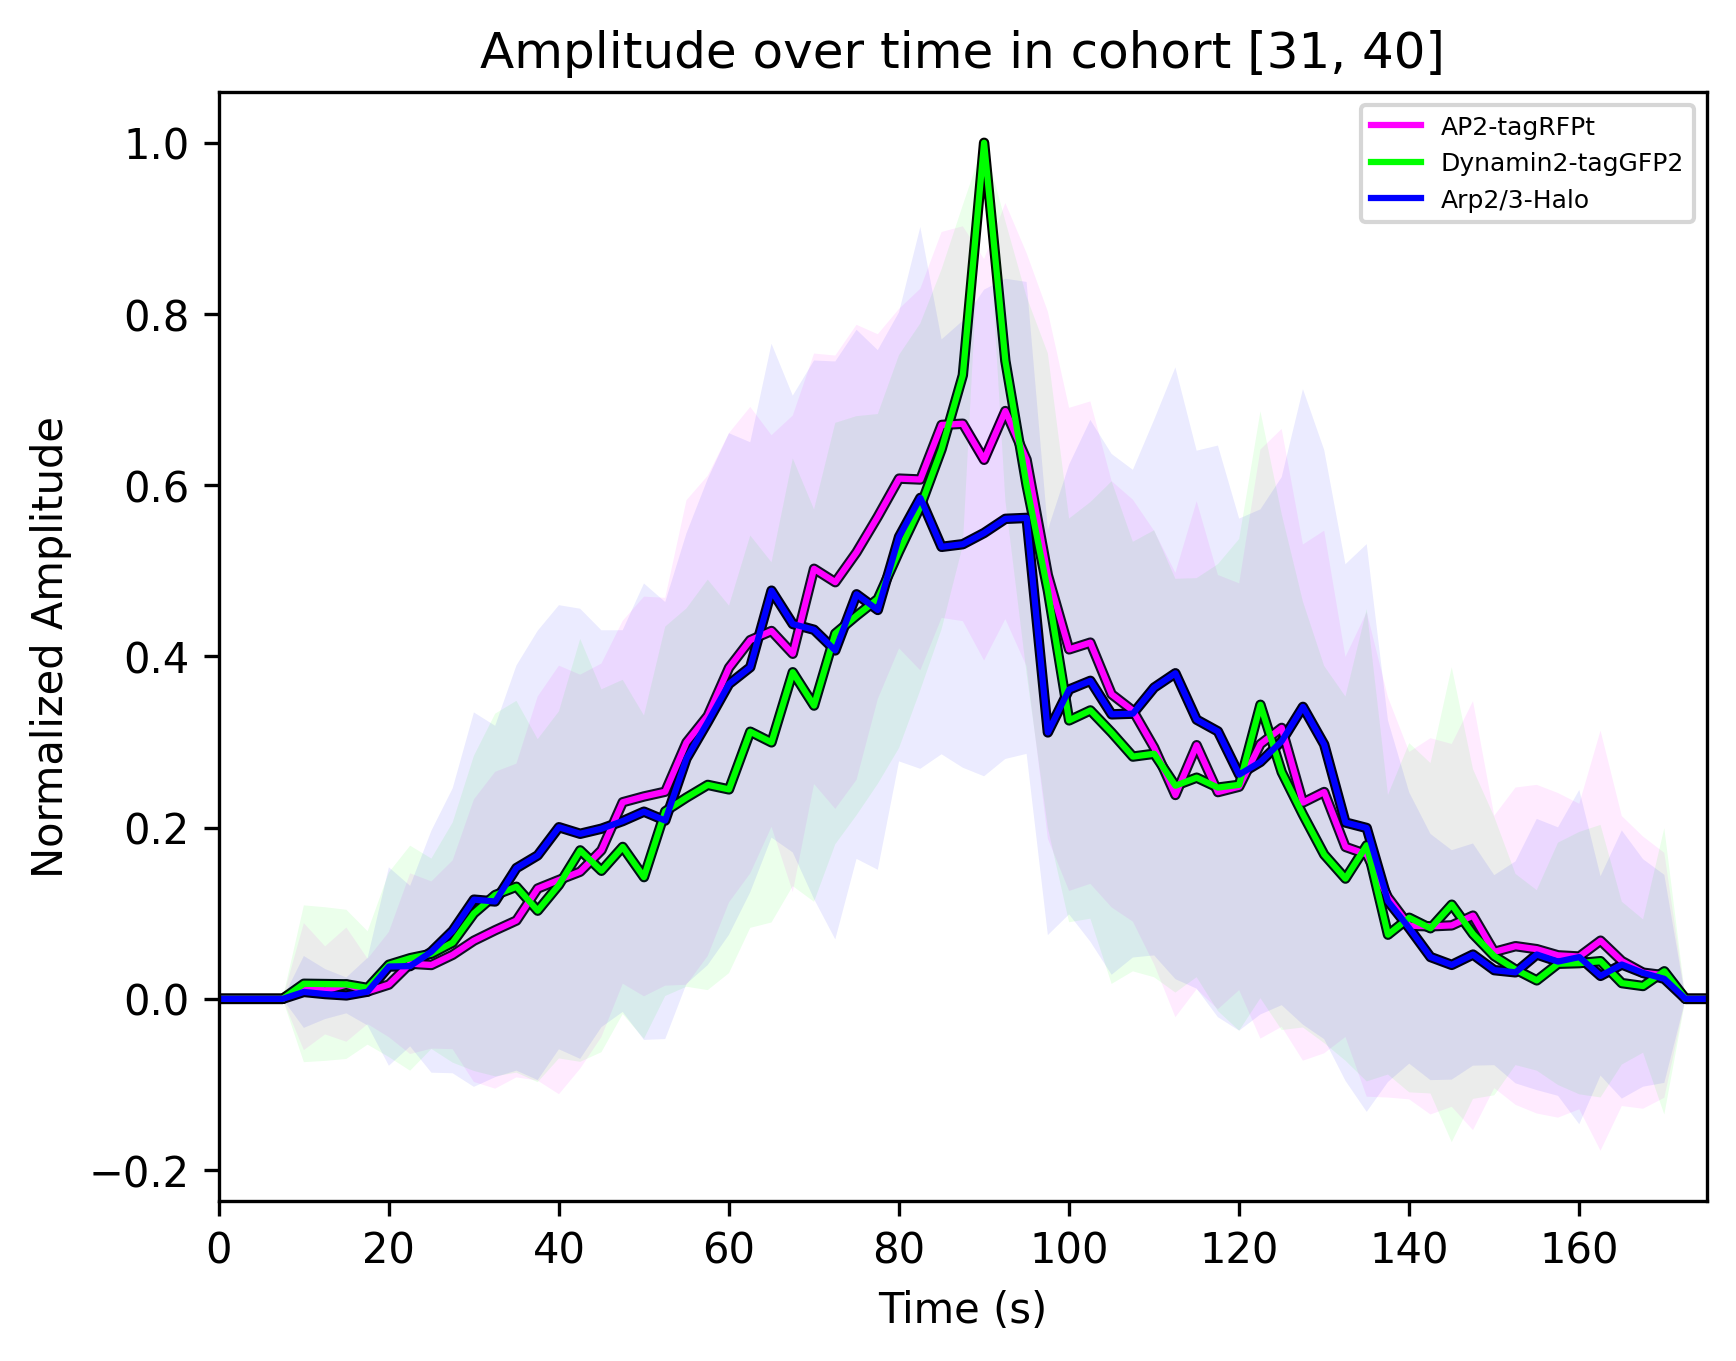

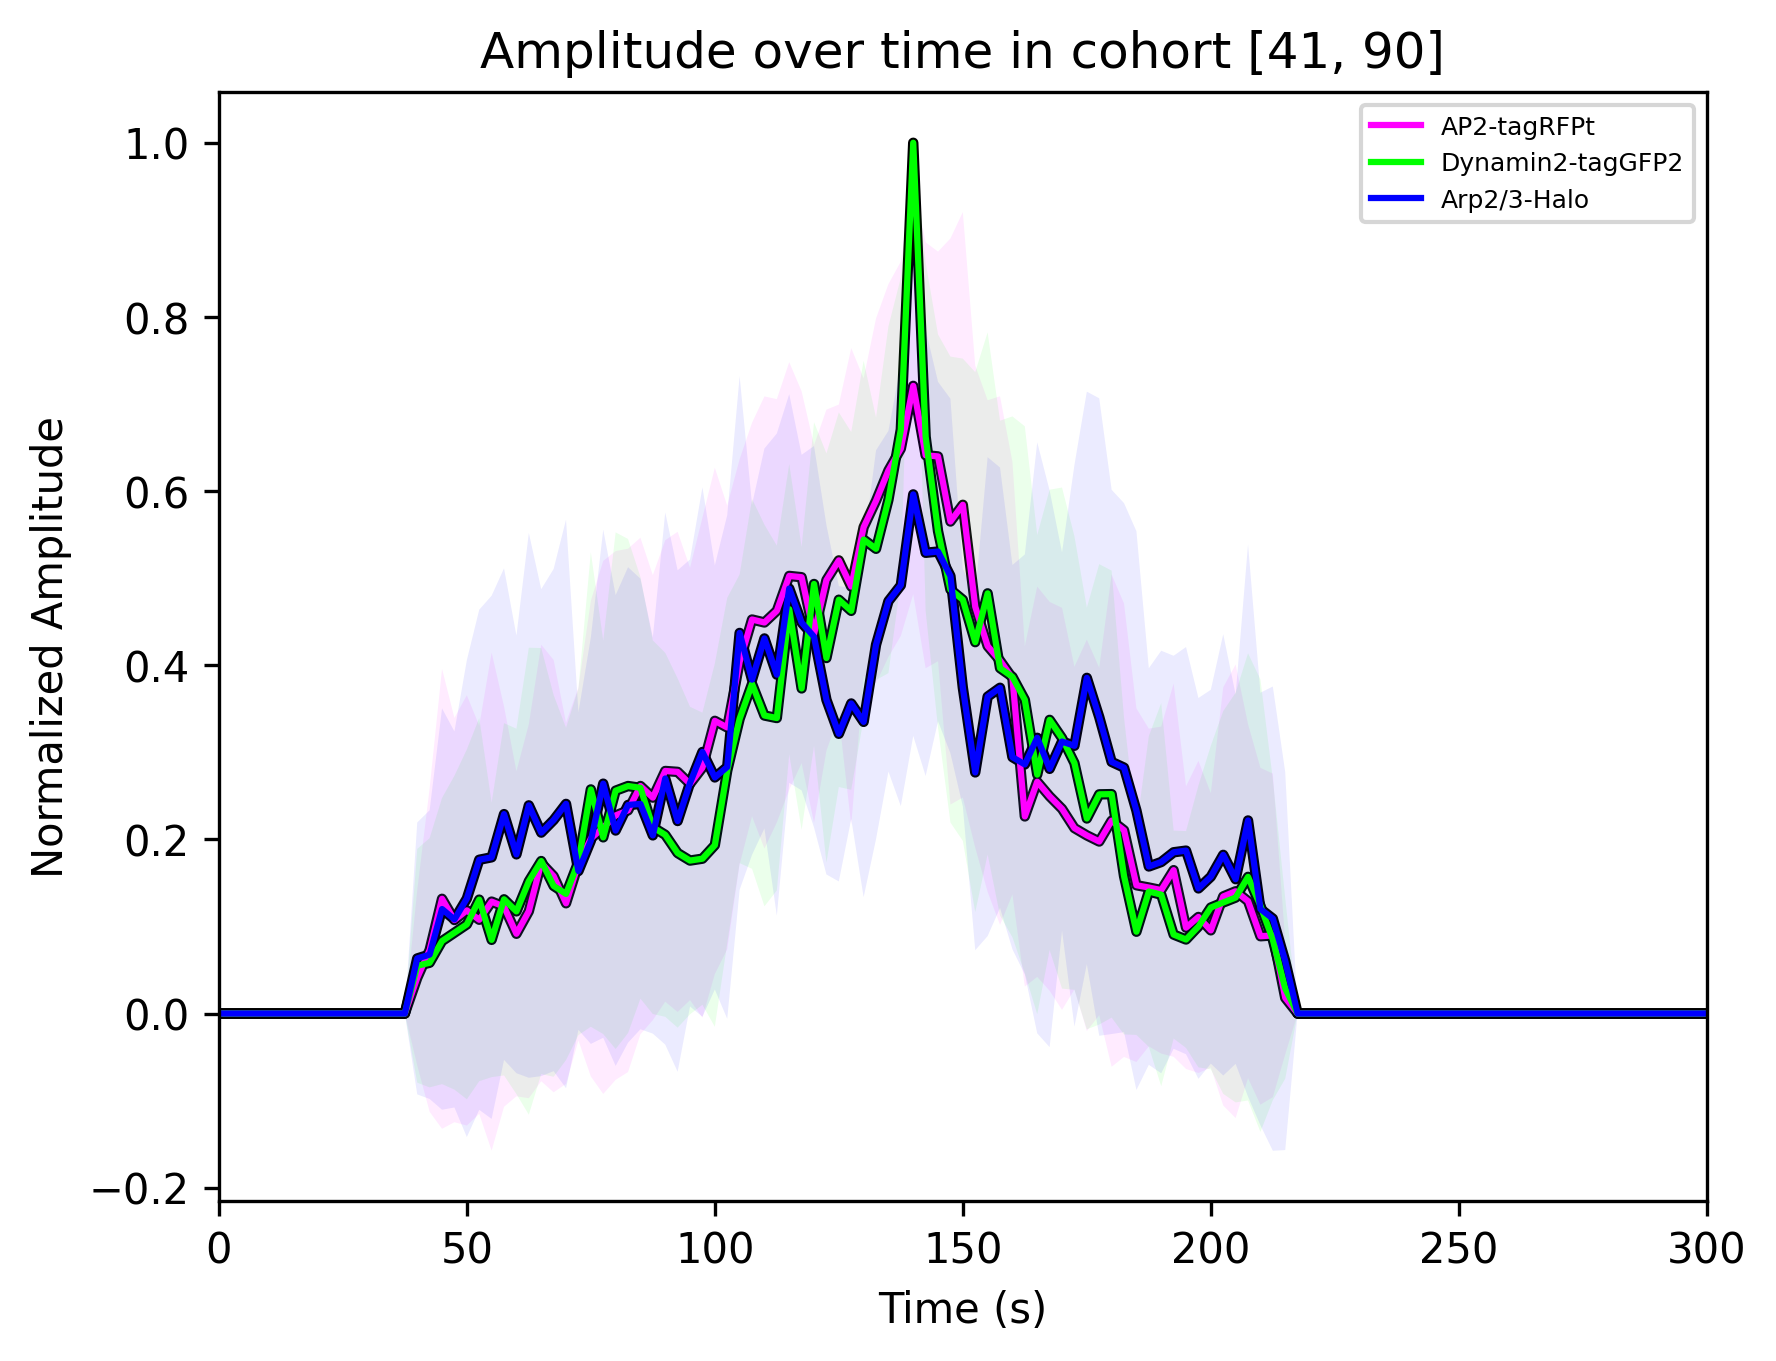

In [17]:
for n, cohort in enumerate(custom_length_ranges):
    primary_buffer, secondary_buffer, tertiary_buffer = createBufferForLifetimeCohort_normalized(dataframe = track_df ,
    listOfTrackIdsAssignedToCohort = track_id_arrays[n], backgroundIntensity = [background_channel_3, background_channel_2, background_channel_1], 
    intensity_to_plot = [f'c3_{value_to_plot}',f'c2_{value_to_plot}', f'c1_{value_to_plot}'], track_id_col_name = 'track_id')
    # intensity_to_plot = ['c3_voxel_sum_adjusted','c2_voxel_sum_adjusted', 'c1_voxel_sum_adjusted'], track_id_col_name = 'track_id')

    cumulative_plots(buffers = [primary_buffer, secondary_buffer, tertiary_buffer],
    background_intensity= [background_channel_3, background_channel_2, background_channel_1], time_shift = 50+cohort[1], framerate_msec = framerate_msec, colors = ['magenta', 'lime', 'blue'], 
                    legend_vals = [channel3_name, channel2_name, channel1_name])
    plt.xlim(0, 75+cohort[1]*framerate_msec/1000)

    plt.title(f'Amplitude over time in cohort {custom_length_ranges[n]}')
    plt.xlabel('Time (s)')
    plt.ylabel('Normalized Amplitude')


In [18]:
# Plot each membrane region separately